## Price is Right Project - Wine Edition

##### Team members: Swapnil Bhagat (Lead), Amanda Monteforte, Xuejing Liu, Fangming Ruan

### Problem Statement

Wine is a popular acoholic beverage, with thousands of varieties produced around the world by thousands of different wineries at a wide range of prices. With so many options, how can a consumer make a purchase knowing that he or she is paying a fair price? In order to answer this question, our team is building a predictive model to determine the price a bottle of wine should be based upon the characteristics of the bottle, and use this projected price to determine whether the wine has a fair retail price.

### Dataset

Data Source: Wine Review Latest https://www.kaggle.com/merkuteharshad/wine-reviews-latest

Dataset used for analysis: winemag-data_first150k.csv & winemag-data-130k-v2.csv

#### Columns in this dataset

General columns in both dataset

| Column Name       | Description     | Type     |
| :------------- | :----------: | :----------- |
|  #  |  ID  |   Integer    |
| Country   | The country in which the wine is produced | String| 
| Description   | The taster's review of the wine | String|
| Designation   | The appellation credentials of the wine | String|
| Points   | The points assigned to the wine by the taster  | Double|
| Price   | The price of the wine | Double|
| Province   | The province in which the wine is produced | String|
| Region_1   | The region in which the wine is produced | String|
| Region_2   | The sub-region in which the wine is produced | String|
| Variety   | The grape type used in producing wine | String|
| Winery   | The winery in which the wine is produced | String||

The specific columns only in the dataset winemag-data-130k-v2.csv

| Column Name       | Description     | Type     |
| :------------- | :---------- | :----------- |
|  taster_name |  The name of the wine reviewer   |   String    |
| taster_twitter_handle   | The twitter link of the taster | String| 
| title   | The title of the wine | String||


### Objectives for Analysis:

1. Find the relationship between both price and the other variables, and points and the other variables: do specific regions, wineries, provinces, or varieties tend to score higher or be priced higher on average?
2. Find the attributes of the top 10% of wines (both in terms of price and points)
3. Is there a relationship between points and price?
4. Find which winery and region has the greatest variety of wine offerings?

### 1. Data Import

#### Import the first dataset and manually define the schema

In [1]:
# Data folder
data = "gs://is843-team3/data/"

In [2]:
# Code to install latest version of seaborn
#!pip install git+https://github.com/mwaskom/seaborn.git
#!pip install seaborn --upgrade

In [3]:
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType

#define schema
ManualSchema = StructType([
    StructField("_c0", IntegerType(), False),
    StructField("country", StringType(), True),
    StructField("description", StringType(), metadata={"maxlength":10000}),
    StructField("designation", StringType(), metadata={"maxlength":1250}),
    StructField("points", StringType(), True),
    StructField("price", StringType(), True),
    StructField("province", StringType(), True),
    StructField("region_1", StringType(), True),
    StructField("region_2", StringType(), True),
    StructField("taster_name", StringType(), True),
    StructField("taster_twitter_handle", StringType(), True),
    StructField("title", StringType(), True),
    StructField("variety", StringType(), True),
    StructField("winery", StringType(), True)
    ])

In [4]:
# loading Wine CSV file
winedf = spark.read.format("csv")\
.schema(ManualSchema)\
.option("header", "true")\
.option("nullValue", "NA")\
.option("escape", ":")\
.load(data + "winemag-data-130k-v2.csv")

In [5]:
# winedf.printSchema()
winedf.toPandas().head(2)

,_c0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0.0,Italy,Aromas include tropical fruit broom brimstone ...,Vulk_ Bianco,87,None,Sicily & Sardinia,Etna,None,Kerin O__eefe,@kerinokeefe,Nicosia 2013 Vulk_ Bianco (Etna),White Blend,Nicosia
1,1.0,Portugal,This is ripe and fruity a wine that is smooth ...,Avidagos,87,15,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


#### Import the second dataset and manually define the schema

In [6]:
#define schema

ManualSchema2 = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("country", StringType(), True),
    StructField("description", StringType(), metadata={"maxlength":10000}),
    StructField("designation", StringType(), True),
    StructField("points", StringType(), True),
    StructField("price", StringType(), True),
    StructField("province", StringType(), True),
    StructField("region_1", StringType(), True),
    StructField("region_2", StringType(), True),
    StructField("variety", StringType(), True),
    StructField("winery", StringType(), True)
    ])

In [7]:
# loading Wine CSV file 2
winedf2 = spark.read.format("csv")\
.schema(ManualSchema2)\
.option("header", "true")\
.option("nullValue", "NA")\
.load(data + "winemag-data_first150k.csv")

In [8]:
winedf2.printSchema()
winedf2.toPandas().head(2)

root
 |-- _c0: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: string (nullable = true)
 |-- price: string (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



,_c0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0.0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1.0,Spain,Ripe aromas of fig blackberry and cassis are s...,Carodorum Selección Especial Reserva,96,110,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez


### 2. Drop unneeded columns

##### Now that we have loaded both our dataset we can drop a few columns which we don't need. Here below columns are only present in winedf and not in winedf2, so we can delete them. It will sync both our dataframes.

In [9]:
# Drop unneeded columns from winedf
cols_to_drop = ['taster_name','taster_twitter_handle','title']
winedf = winedf.drop(*cols_to_drop)
winedf.toPandas().head(2)

,_c0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0.0,Italy,Aromas include tropical fruit broom brimstone ...,Vulk_ Bianco,87,None,Sicily & Sardinia,Etna,None,White Blend,Nicosia
1,1.0,Portugal,This is ripe and fruity a wine that is smooth ...,Avidagos,87,15,Douro,None,None,Portuguese Red,Quinta dos Avidagos


##### Data Examination before Join
##### Checking for important missing data

In [10]:
winedf.toPandas().isna().sum()

_c0                4
country           67
description        4
designation    37470
points             7
price           9003
province          70
region_1       21253
region_2       79465
variety            8
winery             7
dtype: int64

### 3. Joining both dataframes and dropping duplicate records

In [11]:
# after joining we have 280,910 records.
# note: this joined dataframe might have duplicates
winedfTotal = winedf.union(winedf2)
winedfTotal.count()

280910

In [12]:
# after dropping duplicate records we have 280,901 records.
winedfTotal = winedfTotal.dropDuplicates()
winedfTotal.count()

280901

In [13]:
#Total number of duplicate records which we deleted
280910-280901

9

### 4. Data Cleaning

In [14]:
# first lets examine our joined dataframe for missing data. 
# columns - designation and region_2 - have most of the missing values.
winedfTotal.toPandas().isna().sum()

_c0                 1
country            69
description         1
designation     83206
points              9
price           22700
province           77
region_1        46315
region_2       169442
variety            10
winery              9
dtype: int64

In [15]:
# we can clearly see that columns - 
# _c0 and designation have random values which are not useful. 
# column region_2 has either None value or duplicate value as column region_1. 
# so we can drop these columns 
winedfTotal.toPandas().head(5)

,_c0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,70581.0,US,Focus and precision describe this wine. Subtle...,High Slopes,94,40,California,Sierra Foothills,Sierra Foothills,Syrah,Terre Rouge
1,70600.0,Italy,One of the bestselling Proseccos on the planet...,Lunetta,86,14,Veneto,Prosecco,None,Glera,Cavit
2,70902.0,US,A delicious Talley Rincon showing the class of...,Rincon Vineyard,90,58,California,Arroyo Grande Valley,Central Coast,Pinot Noir,Talley
3,70937.0,US,Rose petal notes perfume this intensely aromat...,None,89,16,New York,North Fork of Long Island,Long Island,Rosé,Shinn Estate
4,71013.0,France,Hugely concentrated and packed with tannins th...,None,94,None,Bordeaux,SaintJulien,None,Bordeauxstyle Red Blend,Château Léoville Poyferré


In [16]:
# Drop unneeded columns - '_c0','designation','region_2'
winedfTotal = winedfTotal.drop(*['_c0','designation','region_2'])
winedfTotal.toPandas().head(2)

,country,description,points,price,province,region_1,variety,winery
0,US,Focus and precision describe this wine. Subtle...,94,40,California,Sierra Foothills,Syrah,Terre Rouge
1,Italy,One of the bestselling Proseccos on the planet...,86,14,Veneto,Prosecco,Glera,Cavit


##### we can see that columns price and points are string, so we can convert them to integer

In [17]:
winedfTotal.printSchema()

root
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- points: string (nullable = true)
 |-- price: string (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



In [18]:
# Cast price and points column to integer 
winedfTotal = winedfTotal.withColumn("points", winedfTotal["points"].cast(IntegerType()))
winedfTotal = winedfTotal.withColumn("price", winedfTotal["price"].cast(IntegerType()))
winedfTotal.printSchema()

root
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- points: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



##### We can now check for null values, we are most concerned about price column as it is the most important column in our analysis

In [19]:
winedfTotal.toPandas().isna().sum()

country           69
description        1
points             9
price          22700
province          77
region_1       46315
variety           10
winery             9
dtype: int64

In [20]:
# country column has 69 null data
# we can delete them as it is a tiny percentage of our overall data and we expect data for country for our analysis  
# total records - 280901
# null values for country column - 69
print("% of null countries in entire dataframe: "+str(69*100/280901))

% of null countries in entire dataframe: 0


##### The null percentage of country is only 0.02% in the whole dataset, so we drop those null records.

In [21]:
winedfTotal = winedfTotal.dropna(how='any', subset = ['country'])
winedfTotal.count()

280832

In [22]:
winedfTotal.toPandas().head(5)

,country,description,points,price,province,region_1,variety,winery
0,Italy,Neutral and unassuming on first impact this lu...,85.0,10.0,Central Italy,Montepulciano d'Abruzzo,Montepulciano,Talamonti
1,US,Fruity forward and quite refreshing this has a...,89.0,50.0,Oregon,Willamette Valley,Pinot Noir,Erath
2,Argentina,Roasted woodsy rubbery aromas are gamy and sta...,87.0,15.0,Mendoza Province,Mendoza,Malbec,Bodega Calle
3,US,Here is a solid widely distributed wellpriced ...,88.0,13.0,Washington,Columbia Valley (WA),Chardonnay,Chateau Ste. Michelle
4,Austria,Very subtle but ultimately seductive wild cher...,92.0,NaN,WagramDonauland,None,Pinot Noir,Fritsch


##### Data formatting
###### In order to ensure formatting consistency, and for text analytics, we convert string column values to all uppercase.

In [23]:
# Make text columns all uppercase for text analytics
from pyspark.sql import functions as F
for col in winedfTotal.columns:
    winedfTotal = winedfTotal.withColumn(col, F.upper(F.col(col)))
winedfTotal.toPandas().head(5)

,country,description,points,price,province,region_1,variety,winery
0,US,FOCUS AND PRECISION DESCRIBE THIS WINE. SUBTLE...,94,40,CALIFORNIA,SIERRA FOOTHILLS,SYRAH,TERRE ROUGE
1,ITALY,ONE OF THE BESTSELLING PROSECCOS ON THE PLANET...,86,14,VENETO,PROSECCO,GLERA,CAVIT
2,US,A DELICIOUS TALLEY RINCON SHOWING THE CLASS OF...,90,58,CALIFORNIA,ARROYO GRANDE VALLEY,PINOT NOIR,TALLEY
3,US,ROSE PETAL NOTES PERFUME THIS INTENSELY AROMAT...,89,16,NEW YORK,NORTH FORK OF LONG ISLAND,ROSÉ,SHINN ESTATE
4,FRANCE,HUGELY CONCENTRATED AND PACKED WITH TANNINS TH...,94,None,BORDEAUX,SAINTJULIEN,BORDEAUXSTYLE RED BLEND,CHÂTEAU LÉOVILLE POYFERRÉ


##### Finding and removing outliers in the dataset
###### we can remove outliers from price column i.e. 3 standard deviation away

In [24]:
# Find/Remove outliers
std_value = winedfTotal.agg({'price':'stddev'}).collect()[0][0]
mean_val = winedfTotal.agg({'price':'mean'}).collect()[0][0]

upper_bound = mean_val + (3 * std_value)
lower_bound = mean_val - (3 * std_value)

winedfTotal = winedfTotal.where((winedfTotal['price'] < upper_bound) & (winedfTotal['price'] > lower_bound))

In [25]:
winedfTotal.count()

255564

##### now we can see that our data is clean

In [26]:
winedfTotal.toPandas().isna().sum()

country            0
description        0
points             0
price              0
province           0
region_1       42098
variety            1
winery             0
dtype: int64

##### now that data is clean we can cache our dataframe

In [27]:
winedfTotal.cache()
winedfTotal.storageLevel

StorageLevel(True, True, False, True, 1)

### 5. Data Visualization
#### General Dataset Details

In [29]:
# General dataset details
winedfTotal.createOrReplaceTempView('winedfTotal')
spark.sql(""" \
select count(distinct description) as review_count, count(distinct country) as country_count, \
count(distinct province) as province_count, count(distinct region_1) as region_count, count(distinct variety) as variety_count,\
max(price) as max_price, min(price) as min_price, round(mean(price),0) as avg_price,  \
max(points) as max_points, min(points) as min_points, round(mean(points),0) as avg_points \
from winedfTotal
""").toPandas().head(5)

,review_count,country_count,province_count,region_count,variety_count,max_price,min_price,avg_price,max_points,min_points,avg_points
0,154944,48,482,1287,736,99,10,32.0,99,100,88.0


#### We also look into correlation

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

winedfPandas = winedfTotal.toPandas()
plt.figure(figsize=(16, 10))
corr = winedfPandas.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap="YlGnBu")

##### we found that province and country has high correlation, which makes sense

### Country-level analysis

The details that we care about on this level are the number of reviews per country, mean points, mean price of wine, and the points:price ratio. The points:price ratio tells us the return we're receiving on a bottle of wine, so the higher the ratio, the better quality of wine we're getting for the price we pay. On a country-level, Romania has the best wine for the price being charged, while Italy has the lowest. We limit the dataset to countries with 100 or more reviews so we have volume to back our metrics.

In [31]:
# countries with highest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct country, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count > 100 \
order by points_price_ratio desc
""").toPandas().head(10)

,country,review_count,mean_points,mean_price,points_price_ratio
0,ROMANIA,257,86.0,13.0,6.62
1,BULGARIA,218,87.0,14.0,6.21
2,MOLDOVA,130,86.0,16.0,5.38
3,GEORGIA,127,87.0,19.0,4.58
4,CHILE,10152,86.0,19.0,4.53
5,SOUTH AFRICA,3525,87.0,22.0,3.95
6,GREECE,1333,87.0,22.0,3.95
7,ARGENTINA,9316,86.0,22.0,3.91
8,PORTUGAL,8986,88.0,24.0,3.67
9,CROATIA,154,87.0,24.0,3.63


In [32]:
# countries with lowest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct country, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count > 100 \
order by points_price_ratio
""").toPandas().head(10)

,country,review_count,mean_points,mean_price,points_price_ratio
0,ITALY,35204,88.0,36.0,2.44
1,HUNGARY,367,88.0,35.0,2.51
2,CANADA,448,89.0,35.0,2.54
3,FRANCE,31519,88.0,34.0,2.59
4,US,115907,88.0,34.0,2.59
5,ISRAEL,1099,88.0,32.0,2.75
6,GERMANY,4330,89.0,32.0,2.78
7,AUSTRIA,5277,90.0,30.0,3.00
8,AUSTRALIA,7103,88.0,29.0,3.03
9,MEXICO,133,85.0,28.0,3.04


In [33]:
winedfTotal = winedfTotal.withColumn("points", winedfTotal["points"].cast(IntegerType()))
winedfTotal = winedfTotal.withColumn("price", winedfTotal["price"].cast(IntegerType()))
winePandas = winedfTotal.toPandas()

We use a boxplot to get an indication of how the values in the data are spread out, along with some core metrics about the country (minimum value, first quartile (Q1), median, third quartile (Q3), and maximum value). The following boxplots show the relationship between the country and the points given in the wine ratings, and the relationship between the country and the price of its wine. From the following boxplots, we can see that Turkey tends to be rated very highly, with the highest median review of ~92 points, and tends to be priced fairly reasonably with 75% of prices falling between $18-$25. Brazil, on the otherhand, has a similar price distribution, but has a score range in the low to mid 80s. 

[Text(0,0,'US'),
 Text(0,0,'ITALY'),
 Text(0,0,'FRANCE'),
 Text(0,0,'ARGENTINA'),
 Text(0,0,'PORTUGAL'),
 Text(0,0,'CANADA'),
 Text(0,0,'AUSTRALIA'),
 Text(0,0,'SPAIN'),
 Text(0,0,'CHILE'),
 Text(0,0,'SOUTH AFRICA'),
 Text(0,0,'GERMANY'),
 Text(0,0,'AUSTRIA'),
 Text(0,0,'NEW ZEALAND'),
 Text(0,0,'ENGLAND'),
 Text(0,0,'TURKEY'),
 Text(0,0,'HUNGARY'),
 Text(0,0,'UKRAINE'),
 Text(0,0,'CROATIA'),
 Text(0,0,'BULGARIA'),
 Text(0,0,'GREECE'),
 Text(0,0,'ISRAEL'),
 Text(0,0,'URUGUAY'),
 Text(0,0,'MOLDOVA'),
 Text(0,0,'MEXICO'),
 Text(0,0,'SLOVENIA'),
 Text(0,0,'ROMANIA'),
 Text(0,0,'GEORGIA'),
 Text(0,0,'CYPRUS'),
 Text(0,0,'LEBANON'),
 Text(0,0,'JAPAN'),
 Text(0,0,'MOROCCO'),
 Text(0,0,'MACEDONIA'),
 Text(0,0,'BRAZIL'),
 Text(0,0,'SERBIA'),
 Text(0,0,'ALBANIA'),
 Text(0,0,'SWITZERLAND'),
 Text(0,0,'LUXEMBOURG'),
 Text(0,0,'CZECH REPUBLIC'),
 Text(0,0,'MONTENEGRO'),
 Text(0,0,'PERU'),
 Text(0,0,'INDIA'),
 Text(0,0,'CHINA'),
 Text(0,0,'LITHUANIA'),
 Text(0,0,'SLOVAKIA'),
 Text(0,0,'BOSNIA AND H

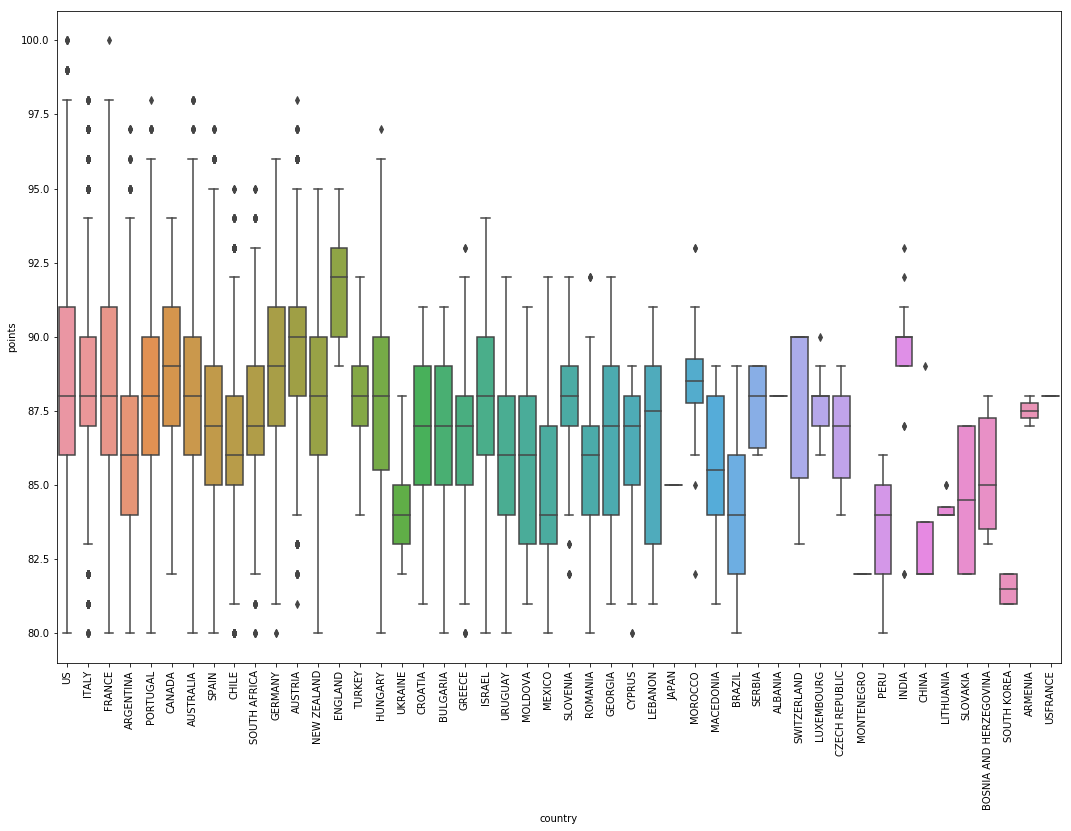

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set size of boxplot
plt.figure(figsize=(18, 12))

# Boxplot of country to points 
ax = sns.boxplot(x="country", y="points", data=winePandas)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0,0,'US'),
 Text(0,0,'ITALY'),
 Text(0,0,'FRANCE'),
 Text(0,0,'ARGENTINA'),
 Text(0,0,'PORTUGAL'),
 Text(0,0,'CANADA'),
 Text(0,0,'AUSTRALIA'),
 Text(0,0,'SPAIN'),
 Text(0,0,'CHILE'),
 Text(0,0,'SOUTH AFRICA'),
 Text(0,0,'GERMANY'),
 Text(0,0,'AUSTRIA'),
 Text(0,0,'NEW ZEALAND'),
 Text(0,0,'ENGLAND'),
 Text(0,0,'TURKEY'),
 Text(0,0,'HUNGARY'),
 Text(0,0,'UKRAINE'),
 Text(0,0,'CROATIA'),
 Text(0,0,'BULGARIA'),
 Text(0,0,'GREECE'),
 Text(0,0,'ISRAEL'),
 Text(0,0,'URUGUAY'),
 Text(0,0,'MOLDOVA'),
 Text(0,0,'MEXICO'),
 Text(0,0,'SLOVENIA'),
 Text(0,0,'ROMANIA'),
 Text(0,0,'GEORGIA'),
 Text(0,0,'CYPRUS'),
 Text(0,0,'LEBANON'),
 Text(0,0,'JAPAN'),
 Text(0,0,'MOROCCO'),
 Text(0,0,'MACEDONIA'),
 Text(0,0,'BRAZIL'),
 Text(0,0,'SERBIA'),
 Text(0,0,'ALBANIA'),
 Text(0,0,'SWITZERLAND'),
 Text(0,0,'LUXEMBOURG'),
 Text(0,0,'CZECH REPUBLIC'),
 Text(0,0,'MONTENEGRO'),
 Text(0,0,'PERU'),
 Text(0,0,'INDIA'),
 Text(0,0,'CHINA'),
 Text(0,0,'LITHUANIA'),
 Text(0,0,'SLOVAKIA'),
 Text(0,0,'BOSNIA AND H

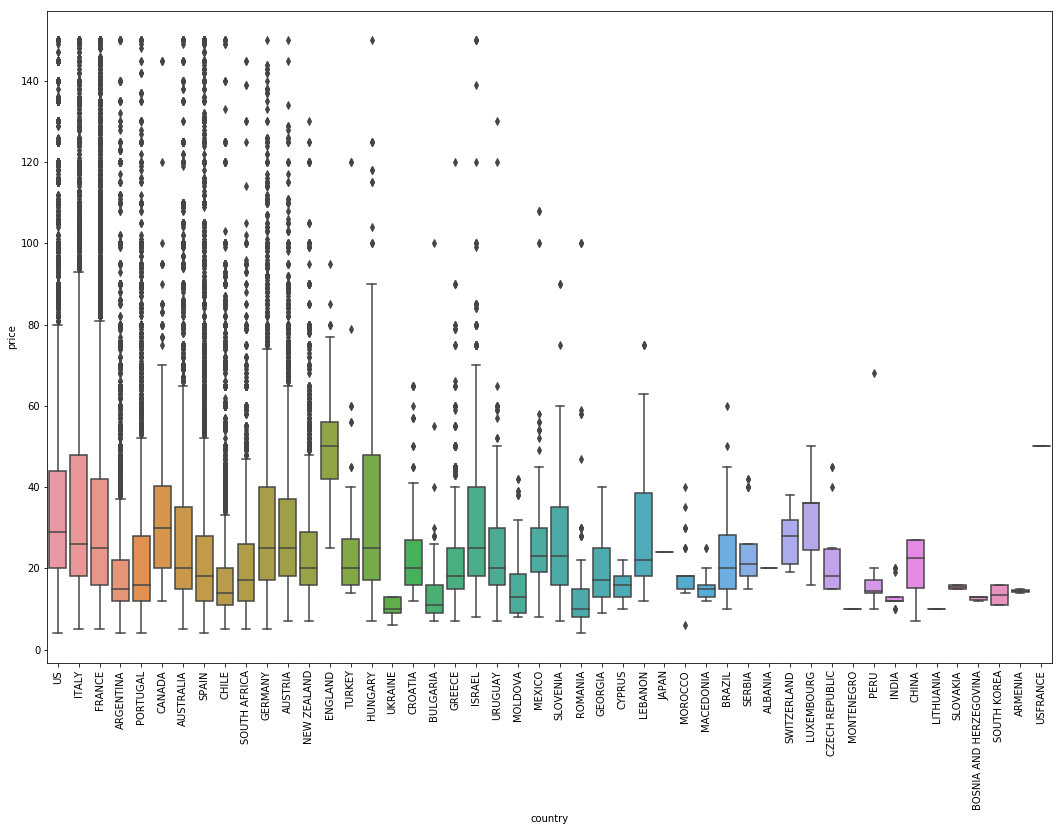

In [35]:
# Set size of boxplot
plt.figure(figsize=(18, 12))

# Boxplot of country to price 
ax = sns.boxplot(x="country", y="price", data=winePandas)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Province-level analysis

We look at the same information at the province-level, but limit the dataset to provinces with 50 or more wine revies. On a province-level, Estremadura, Portugal has the highest points:price ratio, while Champagne, France has the lowest.

In [36]:
# provinces with highest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct province, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio desc
""").toPandas().head(5)


,province,review_count,mean_points,mean_price,points_price_ratio
0,ESTREMADURA,119,87.0,12.0,7.25
1,VINHO VERDE,657,86.0,12.0,7.17
2,AUSTRALIA OTHER,787,85.0,12.0,7.08
3,CENTRAL VALLEY,875,85.0,12.0,7.08
4,THRACIAN VALLEY,154,87.0,14.0,6.21


In [37]:
# provinces with lowest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct province, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio
""").toPandas().head(5)


,province,review_count,mean_points,mean_price,points_price_ratio
0,CHAMPAGNE,2249,90.0,66.0,1.36
1,BURGUNDY,5923,89.0,51.0,1.75
2,BADEN,128,88.0,49.0,1.80
3,ENGLAND,77,92.0,51.0,1.80
4,TOKAJI,109,90.0,47.0,1.91


Because there are 448 distinct provinces in the dataset, we limit the visualizations to show only the top 40 provinces by review volume (and do the same thing for region, variety, and winery since those levels have even more volume). We can see from the following charts that Champagne province in France tends to be high in both ratings and price compared to the other provinces with a high volume of reviews shown.

In [38]:
#limit df to include top 20 regions (in terms of review volume)
top_40_province = spark.sql("""with review_count as ( \
SELECT distinct province, \
count(description) AS review_count_province \
FROM winedfTotal \
group by 1 \
order by 2 desc \
limit 40 \
) \
select w.*, r.review_count_province from winedfTotal w \
inner join review_count r \
on w.province = r.province""")

[Text(0,0,'CALIFORNIA'),
 Text(0,0,'VENETO'),
 Text(0,0,'NEW YORK'),
 Text(0,0,'NORTHEASTERN ITALY'),
 Text(0,0,'BORDEAUX'),
 Text(0,0,'TUSCANY'),
 Text(0,0,'MENDOZA PROVINCE'),
 Text(0,0,'PIEDMONT'),
 Text(0,0,'PROVENCE'),
 Text(0,0,'WASHINGTON'),
 Text(0,0,'ALENTEJANO'),
 Text(0,0,'SOUTHERN ITALY'),
 Text(0,0,'OREGON'),
 Text(0,0,'DOURO'),
 Text(0,0,'ALSACE'),
 Text(0,0,'SOUTH AUSTRALIA'),
 Text(0,0,'NORTHERN SPAIN'),
 Text(0,0,'CHAMPAGNE'),
 Text(0,0,'CATALONIA'),
 Text(0,0,'OTHER'),
 Text(0,0,'SICILY & SARDINIA'),
 Text(0,0,'VIRGINIA'),
 Text(0,0,'SOUTHWEST FRANCE'),
 Text(0,0,'RHÔNE VALLEY'),
 Text(0,0,'LOIRE VALLEY'),
 Text(0,0,'BURGUNDY'),
 Text(0,0,'MARLBOROUGH'),
 Text(0,0,'MOSEL'),
 Text(0,0,'MAIPO VALLEY'),
 Text(0,0,'GALICIA'),
 Text(0,0,'MAULE VALLEY'),
 Text(0,0,'CASABLANCA VALLEY'),
 Text(0,0,'BURGENLAND'),
 Text(0,0,'COLCHAGUA VALLEY'),
 Text(0,0,'CENTRAL ITALY'),
 Text(0,0,'BEAUJOLAIS'),
 Text(0,0,'STELLENBOSCH'),
 Text(0,0,'LANGUEDOCROUSSILLON'),
 Text(0,0,'CENTRAL SP

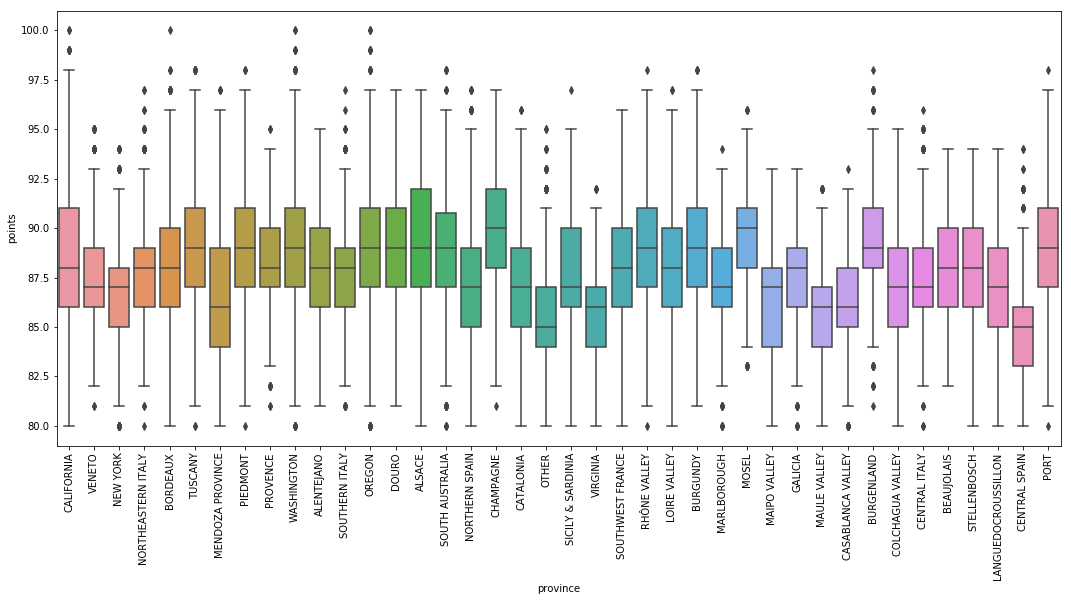

In [39]:
# Boxplot of province to points
top_40_province = top_40_province.withColumn("points", top_40_province["points"].cast(IntegerType()))
top_40_province = top_40_province.withColumn("price", top_40_province["price"].cast(IntegerType()))

# Convert to pandas df
top_40_provincePandas = top_40_province.toPandas()

# Set size of boxplot
plt.figure(figsize=(18, 8))
fx = sns.boxplot(x="province", y="points", data=top_40_provincePandas)
fx.set_xticklabels(fx.get_xticklabels(),rotation=90)

[Text(0,0,'CALIFORNIA'),
 Text(0,0,'VENETO'),
 Text(0,0,'NEW YORK'),
 Text(0,0,'NORTHEASTERN ITALY'),
 Text(0,0,'BORDEAUX'),
 Text(0,0,'TUSCANY'),
 Text(0,0,'MENDOZA PROVINCE'),
 Text(0,0,'PIEDMONT'),
 Text(0,0,'PROVENCE'),
 Text(0,0,'WASHINGTON'),
 Text(0,0,'ALENTEJANO'),
 Text(0,0,'SOUTHERN ITALY'),
 Text(0,0,'OREGON'),
 Text(0,0,'DOURO'),
 Text(0,0,'ALSACE'),
 Text(0,0,'SOUTH AUSTRALIA'),
 Text(0,0,'NORTHERN SPAIN'),
 Text(0,0,'CHAMPAGNE'),
 Text(0,0,'CATALONIA'),
 Text(0,0,'OTHER'),
 Text(0,0,'SICILY & SARDINIA'),
 Text(0,0,'VIRGINIA'),
 Text(0,0,'SOUTHWEST FRANCE'),
 Text(0,0,'RHÔNE VALLEY'),
 Text(0,0,'LOIRE VALLEY'),
 Text(0,0,'BURGUNDY'),
 Text(0,0,'MARLBOROUGH'),
 Text(0,0,'MOSEL'),
 Text(0,0,'MAIPO VALLEY'),
 Text(0,0,'GALICIA'),
 Text(0,0,'MAULE VALLEY'),
 Text(0,0,'CASABLANCA VALLEY'),
 Text(0,0,'BURGENLAND'),
 Text(0,0,'COLCHAGUA VALLEY'),
 Text(0,0,'CENTRAL ITALY'),
 Text(0,0,'BEAUJOLAIS'),
 Text(0,0,'STELLENBOSCH'),
 Text(0,0,'LANGUEDOCROUSSILLON'),
 Text(0,0,'CENTRAL SP

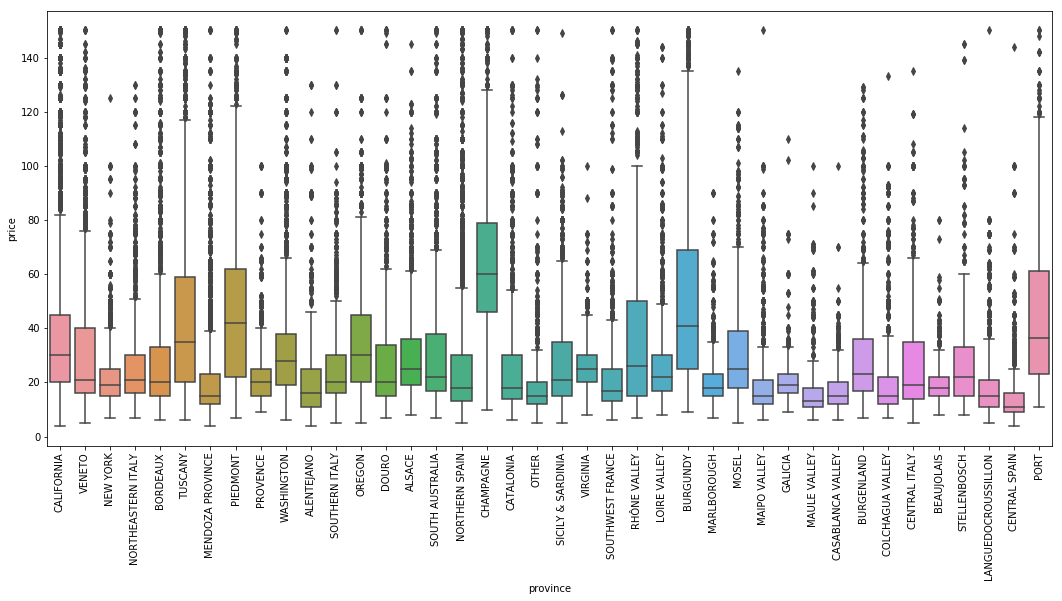

In [40]:
# Boxplot of province to price 
# Set size of boxplot
plt.figure(figsize=(18, 8))
fx = sns.boxplot(x="province", y="price", data=top_40_provincePandas)
fx.set_xticklabels(fx.get_xticklabels(),rotation=90)

### Region-level analysis

On a regional-level, France has both the highest points:price ratio (Vin de Pays de Vaucluse) and the lowest (Vosneromanee).

In [41]:
# regions with highest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct region_1, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio desc
""").toPandas().head(10)


,region_1,review_count,mean_points,mean_price,points_price_ratio
0,VIN DE PAYS DES CÔTES DE GASCOGNE,113,86.0,11.0,7.82
1,VIN DE PAYS D'OC,384,85.0,11.0,7.73
2,TIERRA DE CASTILLA,65,84.0,11.0,7.64
3,CATALUNYA,99,86.0,12.0,7.17
4,CÔTES DE GASCOGNE,261,86.0,12.0,7.17
5,SOUTH EASTERN AUSTRALIA,683,85.0,12.0,7.08
6,LA MANCHA,249,85.0,12.0,7.08
7,CAMPO DE BORJA,329,86.0,13.0,6.62
8,PAYS D'OC,187,86.0,13.0,6.62
9,ENTREDEUXMERS,62,86.0,13.0,6.62


In [42]:
# regions with lowest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct region_1, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio
""").toPandas().head(10)

,region_1,review_count,mean_points,mean_price,points_price_ratio
0,CÔTE RÔTIE,69,91.0,90.0,1.01
1,VOSNEROMANÉE,83,91.0,90.0,1.01
2,HERMITAGE,141,92.0,90.0,1.02
3,CHAMBOLLEMUSIGNY,93,90.0,88.0,1.02
4,NUITSST.GEORGES,214,90.0,85.0,1.06
5,PULIGNYMONTRACHET,189,91.0,83.0,1.10
6,CONDRIEU,82,91.0,81.0,1.12
7,GEVREYCHAMBERTIN,168,91.0,79.0,1.15
8,MEURSAULT,322,90.0,76.0,1.18
9,OAKVILLE,658,90.0,75.0,1.20


On a regional-level, we can observe that California has low ratings, but also very cheap wine with 75% of wines falling between $10-$18. 

In [43]:
#limit df to include top 40 regions (in terms of review volume)
top_40_region = spark.sql("""with review_count as ( \
SELECT distinct region_1, \
count(description) AS review_count_region \
FROM winedfTotal \
group by 1 \
order by 2 desc \
limit 40 \
) \
select w.*, r.review_count_region from winedfTotal w \
inner join review_count r \
on w.region_1 = r.region_1""")

[Text(0,0,'NORTH FORK OF LONG ISLAND'),
 Text(0,0,'DRY CREEK VALLEY'),
 Text(0,0,'PASO ROBLES'),
 Text(0,0,'NAPA VALLEY'),
 Text(0,0,'SANTA BARBARA COUNTY'),
 Text(0,0,'ALTO ADIGE'),
 Text(0,0,'ANDERSON VALLEY'),
 Text(0,0,'MENDOZA'),
 Text(0,0,'BAROLO'),
 Text(0,0,'SONOMA COUNTY'),
 Text(0,0,'CÔTES DE PROVENCE'),
 Text(0,0,'COLUMBIA VALLEY (WA)'),
 Text(0,0,'RED MOUNTAIN'),
 Text(0,0,'HORSE HEAVEN HILLS'),
 Text(0,0,'YAKIMA VALLEY'),
 Text(0,0,'LODI'),
 Text(0,0,'TOSCANA'),
 Text(0,0,'WILLAMETTE VALLEY'),
 Text(0,0,'RIOJA'),
 Text(0,0,'RUSSIAN RIVER VALLEY'),
 Text(0,0,'CHAMPAGNE'),
 Text(0,0,'SONOMA COAST'),
 Text(0,0,'WALLA WALLA VALLEY (WA)'),
 Text(0,0,'FINGER LAKES'),
 Text(0,0,'CALIFORNIA'),
 Text(0,0,'ALSACE'),
 Text(0,0,'CHIANTI CLASSICO'),
 Text(0,0,'SANTA MARIA VALLEY'),
 Text(0,0,'RIBERA DEL DUERO'),
 Text(0,0,'CARNEROS'),
 Text(0,0,'ALEXANDER VALLEY'),
 Text(0,0,'STA. RITA HILLS'),
 Text(0,0,'SANTA LUCIA HIGHLANDS'),
 Text(0,0,'CENTRAL COAST'),
 Text(0,0,'CAVA'),
 Text(0,0

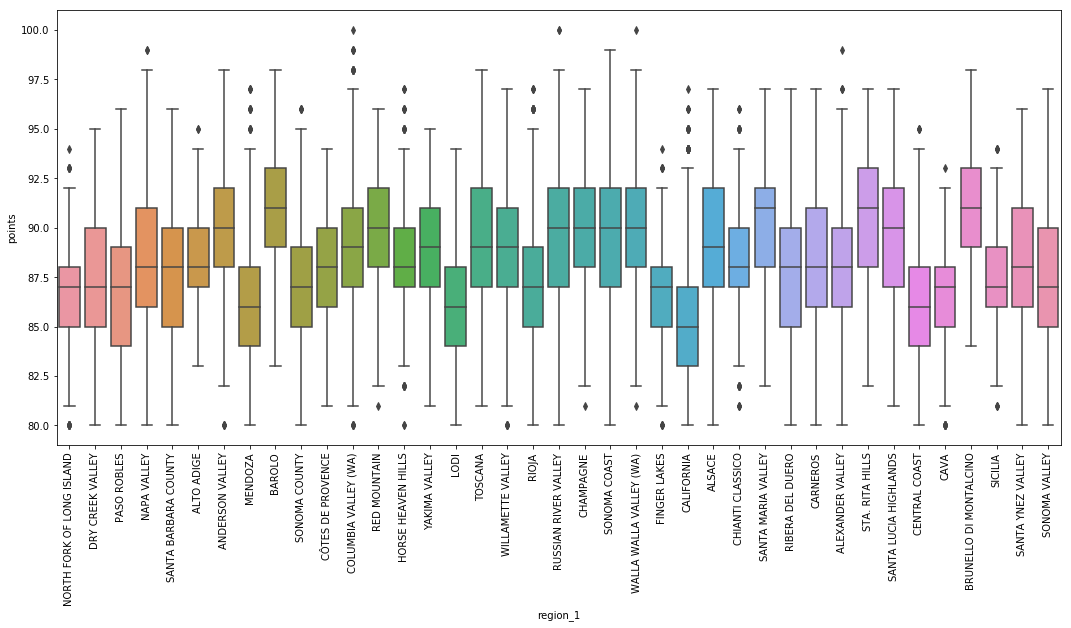

In [44]:
# Boxplot of region to points 

top_40_region = top_40_region.withColumn("points", top_40_region["points"].cast(IntegerType()))
top_40_region = top_40_region.withColumn("price", top_40_region["price"].cast(IntegerType()))

# Convert to pandas df
top_40_regionPandas = top_40_region.toPandas()

# Set size of boxplot
plt.figure(figsize=(18, 8))
fx = sns.boxplot(x="region_1", y="points", data=top_40_regionPandas)
fx.set_xticklabels(fx.get_xticklabels(),rotation=90)

[Text(0,0,'NORTH FORK OF LONG ISLAND'),
 Text(0,0,'DRY CREEK VALLEY'),
 Text(0,0,'PASO ROBLES'),
 Text(0,0,'NAPA VALLEY'),
 Text(0,0,'SANTA BARBARA COUNTY'),
 Text(0,0,'ALTO ADIGE'),
 Text(0,0,'ANDERSON VALLEY'),
 Text(0,0,'MENDOZA'),
 Text(0,0,'BAROLO'),
 Text(0,0,'SONOMA COUNTY'),
 Text(0,0,'CÔTES DE PROVENCE'),
 Text(0,0,'COLUMBIA VALLEY (WA)'),
 Text(0,0,'RED MOUNTAIN'),
 Text(0,0,'HORSE HEAVEN HILLS'),
 Text(0,0,'YAKIMA VALLEY'),
 Text(0,0,'LODI'),
 Text(0,0,'TOSCANA'),
 Text(0,0,'WILLAMETTE VALLEY'),
 Text(0,0,'RIOJA'),
 Text(0,0,'RUSSIAN RIVER VALLEY'),
 Text(0,0,'CHAMPAGNE'),
 Text(0,0,'SONOMA COAST'),
 Text(0,0,'WALLA WALLA VALLEY (WA)'),
 Text(0,0,'FINGER LAKES'),
 Text(0,0,'CALIFORNIA'),
 Text(0,0,'ALSACE'),
 Text(0,0,'CHIANTI CLASSICO'),
 Text(0,0,'SANTA MARIA VALLEY'),
 Text(0,0,'RIBERA DEL DUERO'),
 Text(0,0,'CARNEROS'),
 Text(0,0,'ALEXANDER VALLEY'),
 Text(0,0,'STA. RITA HILLS'),
 Text(0,0,'SANTA LUCIA HIGHLANDS'),
 Text(0,0,'CENTRAL COAST'),
 Text(0,0,'CAVA'),
 Text(0,0

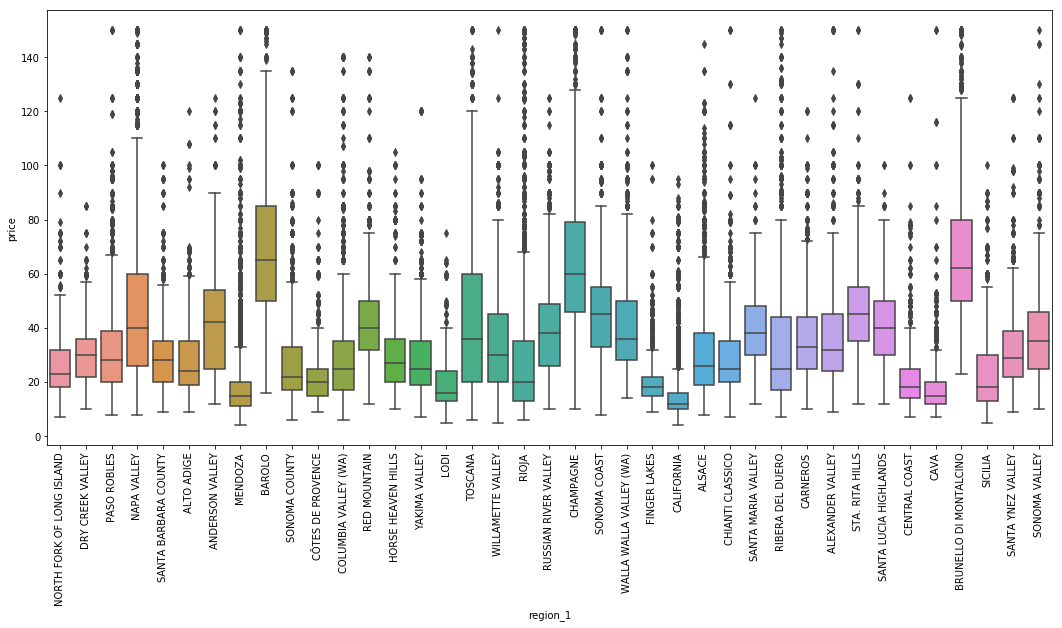

In [45]:
# Boxplot of region to price 

# Set size of boxplot
plt.figure(figsize=(18, 8))
fx = sns.boxplot(x="region_1", y="price", data=top_40_regionPandas)
fx.set_xticklabels(fx.get_xticklabels(),rotation=90)

### Variety-level analysis

On a variety-level, the points: price ratio is highest for the Tempranillo-Garnacha variety from Spain, and lowest for the Nebbiolo variety from Italy.

In [46]:
# varieties with highest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct variety, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio desc
""").toPandas().head(10)

,variety,review_count,mean_points,mean_price,points_price_ratio
0,TEMPRANILLOGARNACHA,92,84.0,11.0,7.64
1,LOUREIRO,58,88.0,13.0,6.77
2,CASTELÃO,69,87.0,13.0,6.69
3,TORRONTÉS,610,85.0,13.0,6.54
4,ROSADO,98,85.0,13.0,6.54
5,VIURA,215,85.0,14.0,6.07
6,MOSCHOFILERO,80,87.0,15.0,5.80
7,CHENIN BLANCCHARDONNAY,57,87.0,15.0,5.80
8,PORTUGUESE WHITE,1702,87.0,15.0,5.80
9,INZOLIA,53,86.0,15.0,5.73


In [47]:
# varieties with lowest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct variety, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio
""").toPandas().head(10)

,variety,review_count,mean_points,mean_price,points_price_ratio
0,NEBBIOLO,3742,90.0,61.0,1.48
1,SPÄTBURGUNDER,122,89.0,59.0,1.51
2,CHAMPAGNE BLEND,2030,89.0,58.0,1.53
3,SANGIOVESE GROSSO,1496,91.0,59.0,1.54
4,TOKAJI,90,91.0,58.0,1.57
5,SAGRANTINO,175,90.0,52.0,1.73
6,CABERNET BLEND,363,89.0,49.0,1.82
7,TINTO FINO,153,89.0,49.0,1.82
8,CLARET,70,88.0,46.0,1.91
9,PETITE VERDOT,101,87.0,44.0,1.98


On a variety-level, we start to notice a correlation between ratings and price, with the higher-priced wines being rated higher by critics. This observation leads us to believe that a reviewer may be biased by a higher price to believe the wine is better quality.

In [48]:
# Limit to top 20 varieties by review volume (following visualizations too dense otherwise)

top_40_variety = spark.sql("""with variety_count as ( \
SELECT distinct variety, \
count(description) AS review_count_variety \
FROM winedfTotal \
group by 1 \
order by 2 desc \
limit 40 \
) \
select w.*, r.review_count_variety from winedfTotal w \
inner join variety_count r \
on w.variety = r.variety""")
# top_20.show()

[Text(0,0,'SYRAH'),
 Text(0,0,'GLERA'),
 Text(0,0,'PINOT NOIR'),
 Text(0,0,'ROSÉ'),
 Text(0,0,'ZINFANDEL'),
 Text(0,0,'CABERNET SAUVIGNON'),
 Text(0,0,'WHITE BLEND'),
 Text(0,0,'RIESLING'),
 Text(0,0,'BORDEAUXSTYLE RED BLEND'),
 Text(0,0,'RED BLEND'),
 Text(0,0,'MALBEC'),
 Text(0,0,'NEBBIOLO'),
 Text(0,0,'RHÔNESTYLE RED BLEND'),
 Text(0,0,'CHARDONNAY'),
 Text(0,0,'MERLOT'),
 Text(0,0,'PETITE SIRAH'),
 Text(0,0,'PORTUGUESE RED'),
 Text(0,0,'CABERNET FRANC'),
 Text(0,0,'SPARKLING BLEND'),
 Text(0,0,'GRENACHE'),
 Text(0,0,'VIOGNIER'),
 Text(0,0,'CHAMPAGNE BLEND'),
 Text(0,0,'PINOT GRIGIO'),
 Text(0,0,'PINOT GRIS'),
 Text(0,0,'SAUVIGNON BLANC'),
 Text(0,0,'GRÜNER VELTLINER'),
 Text(0,0,'CORVINA RONDINELLA MOLINARA'),
 Text(0,0,'TEMPRANILLO'),
 Text(0,0,'TEMPRANILLO BLEND'),
 Text(0,0,'SANGIOVESE'),
 Text(0,0,'BORDEAUXSTYLE WHITE BLEND'),
 Text(0,0,'GEWÜRZTRAMINER'),
 Text(0,0,'SHIRAZ'),
 Text(0,0,'BARBERA'),
 Text(0,0,'SANGIOVESE GROSSO'),
 Text(0,0,'CHENIN BLANC'),
 Text(0,0,'GAMAY'),
 Te

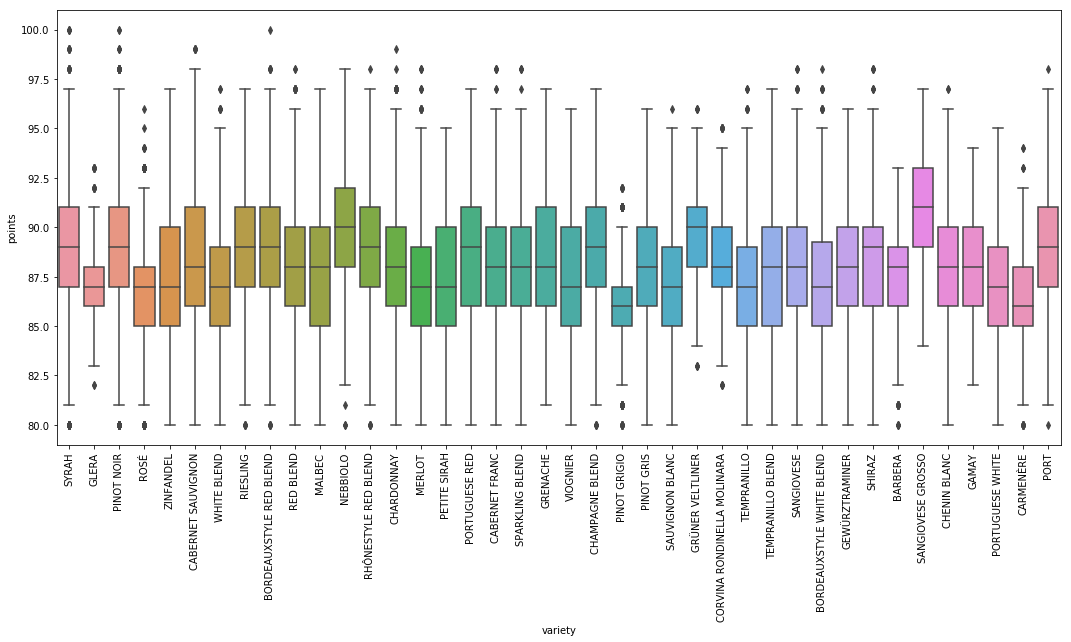

In [49]:
# Boxplot of varieties to points 
top_40_variety = top_40_variety.withColumn("points", top_40_variety["points"].cast(IntegerType()))
top_40_variety = top_40_variety.withColumn("price", top_40_variety["price"].cast(IntegerType()))
# Convert to pandas df
top_40_varietyPandas = top_40_variety.toPandas()

# Set size of boxplot
plt.figure(figsize=(18, 8))
dx = sns.boxplot(x="variety", y="points", data = top_40_varietyPandas)
dx.set_xticklabels(dx.get_xticklabels(),rotation=90)

[Text(0,0,'SYRAH'),
 Text(0,0,'GLERA'),
 Text(0,0,'PINOT NOIR'),
 Text(0,0,'ROSÉ'),
 Text(0,0,'ZINFANDEL'),
 Text(0,0,'CABERNET SAUVIGNON'),
 Text(0,0,'WHITE BLEND'),
 Text(0,0,'RIESLING'),
 Text(0,0,'BORDEAUXSTYLE RED BLEND'),
 Text(0,0,'RED BLEND'),
 Text(0,0,'MALBEC'),
 Text(0,0,'NEBBIOLO'),
 Text(0,0,'RHÔNESTYLE RED BLEND'),
 Text(0,0,'CHARDONNAY'),
 Text(0,0,'MERLOT'),
 Text(0,0,'PETITE SIRAH'),
 Text(0,0,'PORTUGUESE RED'),
 Text(0,0,'CABERNET FRANC'),
 Text(0,0,'SPARKLING BLEND'),
 Text(0,0,'GRENACHE'),
 Text(0,0,'VIOGNIER'),
 Text(0,0,'CHAMPAGNE BLEND'),
 Text(0,0,'PINOT GRIGIO'),
 Text(0,0,'PINOT GRIS'),
 Text(0,0,'SAUVIGNON BLANC'),
 Text(0,0,'GRÜNER VELTLINER'),
 Text(0,0,'CORVINA RONDINELLA MOLINARA'),
 Text(0,0,'TEMPRANILLO'),
 Text(0,0,'TEMPRANILLO BLEND'),
 Text(0,0,'SANGIOVESE'),
 Text(0,0,'BORDEAUXSTYLE WHITE BLEND'),
 Text(0,0,'GEWÜRZTRAMINER'),
 Text(0,0,'SHIRAZ'),
 Text(0,0,'BARBERA'),
 Text(0,0,'SANGIOVESE GROSSO'),
 Text(0,0,'CHENIN BLANC'),
 Text(0,0,'GAMAY'),
 Te

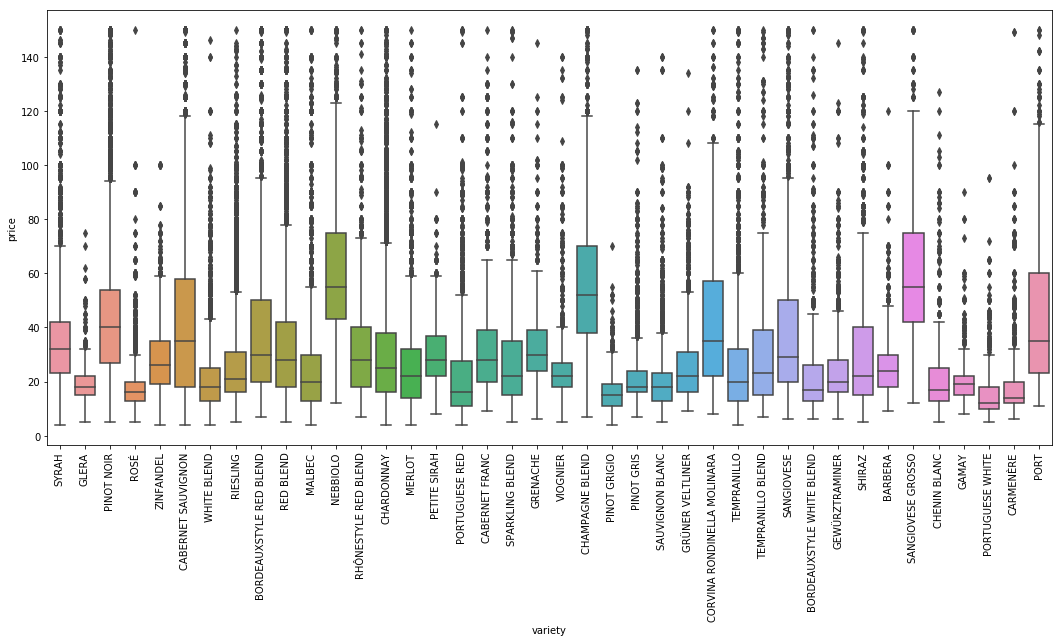

In [50]:
# Boxplot of varieties to price 
# Set size of boxplot
plt.figure(figsize=(18, 8))
dx = sns.boxplot(x="variety", y="price", data = top_40_varietyPandas)
dx.set_xticklabels(dx.get_xticklabels(),rotation=90)

### Winery-level analysis

On a variety-level, the Funky Llama winery in Argentina has the highest points:price ratio, and the Goldschmidt winery in California has the lowest.

In [51]:
# wineries with highest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct winery, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio desc
""").toPandas().head(10)

,winery,review_count,mean_points,mean_price,points_price_ratio
0,FUNKY LLAMA,87,83.0,6.0,13.83
1,WOODBRIDGE BY ROBERT MONDAVI,82,85.0,8.0,10.63
2,OAK GROVE,81,84.0,8.0,10.50
3,BORSAO,81,86.0,9.0,9.56
4,CRAMELE RECAS,80,86.0,9.0,9.56
5,GLEN ELLEN,62,83.0,9.0,9.22
6,COVEY RUN,107,86.0,10.0,8.60
7,WASHINGTON HILLS,56,86.0,10.0,8.60
8,ADEGA COOPERATIVA DO CARTAXO,57,86.0,10.0,8.60
9,TILIA,53,86.0,10.0,8.60


In [52]:
# wineries with lowest point to price ratio
spark.sql(""" \
select *, round(mean_points/mean_price,2) as points_price_ratio from ( \
SELECT distinct winery, \
count(description) as review_count, round(mean(points),0) as mean_points, round(mean(price),0) as mean_price \
FROM winedfTotal \
group by 1) \
where review_count >50 \
order by points_price_ratio 
""").toPandas().head(10)

,winery,review_count,mean_points,mean_price,points_price_ratio
0,GOLDSCHMIDT,56,93.0,99.0,0.94
1,JARVIS,71,91.0,94.0,0.97
2,QUILCEDA CREEK,54,94.0,90.0,1.04
3,BLACKBIRD VINEYARDS,64,91.0,85.0,1.07
4,LEONETTI CELLAR,91,94.0,86.0,1.09
5,POGGIO ANTICO,64,91.0,82.0,1.11
6,ARCHERY SUMMIT,72,91.0,81.0,1.12
7,PIÑA,51,92.0,81.0,1.14
8,VINE CLIFF,75,92.0,80.0,1.15
9,GRATTAMACCO,51,90.0,77.0,1.17


On a winery-level, the following visualizations are more an indication of the size of the winery. A winery with a large price range like Louis Latour is more likely to offer more variety/a larger collection of wine, as opposed to Hogue, which likely offers less variety.

In [53]:
# Limit to top 40 varieties by review volume (following visualizations too dense otherwise)

top_40_winery = spark.sql("""with winery_count as ( \
SELECT distinct winery, \
count(description) AS review_count_winery \
FROM winedfTotal \
group by 1 \
order by 2 desc \
limit 40 \
) \
select w.*, r.review_count_winery from winedfTotal w \
inner join winery_count r \
on w.winery = r.winery""")
# top_20.show()

[Text(0,0,'FESS PARKER'),
 Text(0,0,'RODNEY STRONG'),
 Text(0,0,'WILLIAMS SELYEM'),
 Text(0,0,'BOUCHARD PÈRE & FILS'),
 Text(0,0,'IRON HORSE'),
 Text(0,0,'SINEANN'),
 Text(0,0,'LOUIS LATOUR'),
 Text(0,0,'ROBERT MONDAVI'),
 Text(0,0,'DFJ VINHOS'),
 Text(0,0,'MORGAN'),
 Text(0,0,'WINES & WINEMAKERS'),
 Text(0,0,'JOSEPH DROUHIN'),
 Text(0,0,'CALERA'),
 Text(0,0,'SIDURI'),
 Text(0,0,'CONCANNON'),
 Text(0,0,'GARY FARRELL'),
 Text(0,0,'LYNMAR'),
 Text(0,0,'CHATEAU STE. MICHELLE'),
 Text(0,0,'SEVEN HILLS'),
 Text(0,0,'CAMERON HUGHES'),
 Text(0,0,'DE LOACH'),
 Text(0,0,'COLUMBIA CREST'),
 Text(0,0,'TRAPICHE'),
 Text(0,0,'MARTIN RAY'),
 Text(0,0,'TESTAROSSA'),
 Text(0,0,'ERRAZURIZ'),
 Text(0,0,'KENDALLJACKSON'),
 Text(0,0,'DRY CREEK VINEYARD'),
 Text(0,0,'CONCHA Y TORO'),
 Text(0,0,'KENWOOD'),
 Text(0,0,'SANTA EMA'),
 Text(0,0,"D'ARENBERG"),
 Text(0,0,'MONTES'),
 Text(0,0,'WATERBROOK'),
 Text(0,0,'KUNDE'),
 Text(0,0,"L'ECOLE NO. 41"),
 Text(0,0,'SANTA RITA'),
 Text(0,0,'HOGUE'),
 Text(0,0,'DUTT

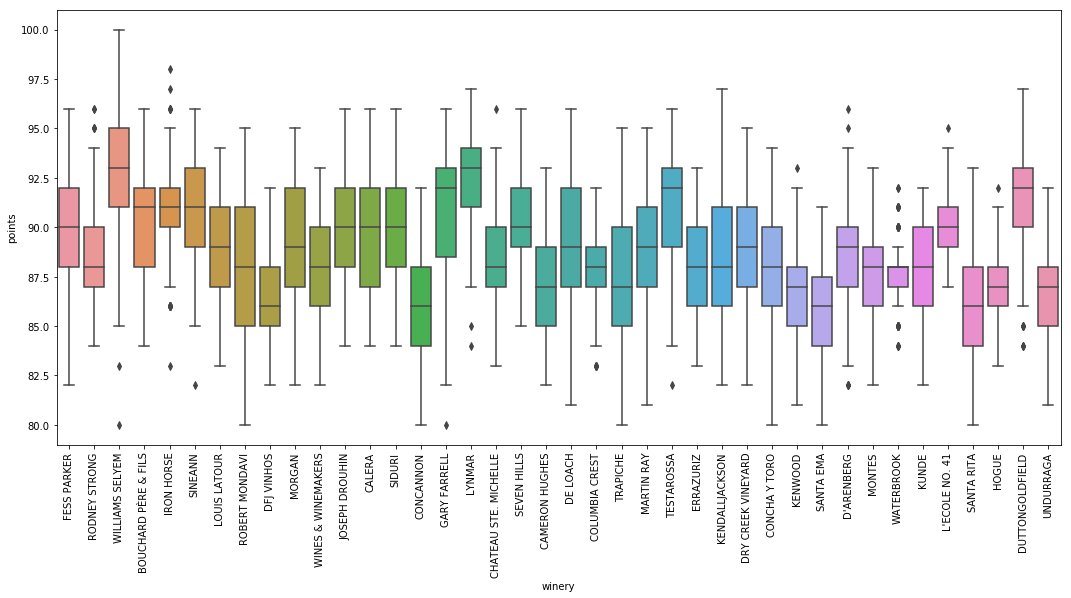

In [54]:
# Boxplot of wineries to points 

top_40_winery = top_40_winery.withColumn("points", top_40_winery["points"].cast(IntegerType()))
top_40_winery = top_40_winery.withColumn("price", top_40_winery["price"].cast(IntegerType()))

# Convert to pandas df
top_40_wineryPandas = top_40_winery.toPandas()

# Set size of boxplot
plt.figure(figsize=(18, 8))
dx = sns.boxplot(x="winery", y="points", data = top_40_wineryPandas)
dx.set_xticklabels(dx.get_xticklabels(),rotation=90)

[Text(0,0,'FESS PARKER'),
 Text(0,0,'RODNEY STRONG'),
 Text(0,0,'WILLIAMS SELYEM'),
 Text(0,0,'BOUCHARD PÈRE & FILS'),
 Text(0,0,'IRON HORSE'),
 Text(0,0,'SINEANN'),
 Text(0,0,'LOUIS LATOUR'),
 Text(0,0,'ROBERT MONDAVI'),
 Text(0,0,'DFJ VINHOS'),
 Text(0,0,'MORGAN'),
 Text(0,0,'WINES & WINEMAKERS'),
 Text(0,0,'JOSEPH DROUHIN'),
 Text(0,0,'CALERA'),
 Text(0,0,'SIDURI'),
 Text(0,0,'CONCANNON'),
 Text(0,0,'GARY FARRELL'),
 Text(0,0,'LYNMAR'),
 Text(0,0,'CHATEAU STE. MICHELLE'),
 Text(0,0,'SEVEN HILLS'),
 Text(0,0,'CAMERON HUGHES'),
 Text(0,0,'DE LOACH'),
 Text(0,0,'COLUMBIA CREST'),
 Text(0,0,'TRAPICHE'),
 Text(0,0,'MARTIN RAY'),
 Text(0,0,'TESTAROSSA'),
 Text(0,0,'ERRAZURIZ'),
 Text(0,0,'KENDALLJACKSON'),
 Text(0,0,'DRY CREEK VINEYARD'),
 Text(0,0,'CONCHA Y TORO'),
 Text(0,0,'KENWOOD'),
 Text(0,0,'SANTA EMA'),
 Text(0,0,"D'ARENBERG"),
 Text(0,0,'MONTES'),
 Text(0,0,'WATERBROOK'),
 Text(0,0,'KUNDE'),
 Text(0,0,"L'ECOLE NO. 41"),
 Text(0,0,'SANTA RITA'),
 Text(0,0,'HOGUE'),
 Text(0,0,'DUTT

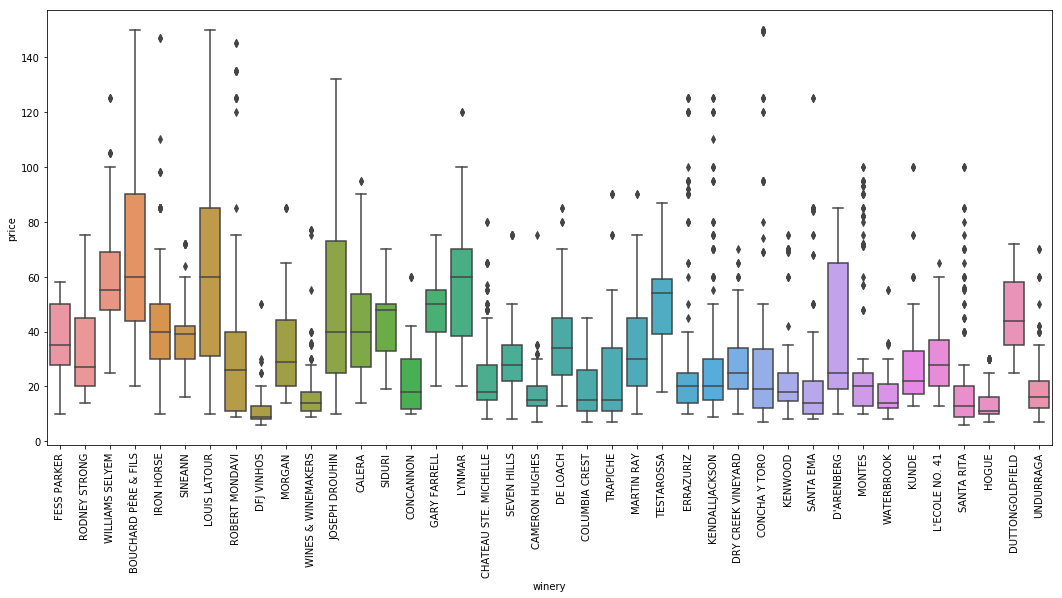

In [55]:
# Boxplot of wineries to price 
# Set size of boxplot
plt.figure(figsize=(18, 8))
dx = sns.boxplot(x="winery", y="price", data = top_40_wineryPandas)
dx.set_xticklabels(dx.get_xticklabels(),rotation=90)

### What are the attributes of top 10% of wines (both in terms of price and points)

In [56]:
# Top 10% of wines in price
from pyspark.sql.functions import desc

# Getting top 10% of records by price
winedfTotal = winedfTotal.sort(desc("price"))
top_10_perc_count = winedfTotal.count()/10
winedfTotal.createOrReplaceTempView('winedfTotal')
top_10_perc_price = spark.sql("SELECT * FROM winedfTotal LIMIT {}".format(int(top_10_perc_count)))
top_10_perc_price.toPandas().head(10)

,country,description,points,price,province,region_1,variety,winery
0,US,THIS IS A DELIGHTFULLY DENSE YET HERBAL AND WE...,92,150,CALIFORNIA,OAKVILLE,CABERNET SAUVIGNON,GOLDSCHMIDT
1,SPAIN,GORGEOUS AROMAS OF TOASTY OAK WOOD SMOKE MINER...,97,150,NORTHERN SPAIN,RIBERA DEL DUERO,TINTO FINO,EMILIO MORO
2,US,THIS IS CERTAINLY DRAMATIC IN STRUCTURE AKIN T...,93,150,CALIFORNIA,NAPA VALLEY,CABERNET SAUVIGNON,VINE CLIFF
3,US,THIS COMBINES NEARLY PROPORTIONAL PERCENTAGES ...,93,150,CALIFORNIA,CALISTOGA,BORDEAUXSTYLE RED BLEND,KENEFICK RANCH
4,US,THIS IS ACTUALLY A 100% VARIETAL CABERNET SAUV...,94,150,CALIFORNIA,NAPA VALLEY,BORDEAUXSTYLE RED BLEND,BOESCHEN VINEYARDS
5,FRANCE,THE GREAT 2008 VINTAGE HAS PRODUCED A TEXTURED...,94,150,CHAMPAGNE,CHAMPAGNE,CHAMPAGNE BLEND,SOUTIRAN
6,US,EXOTIC IN COCONUT MACAROON ON THE NOSE THIS WI...,91,150,CALIFORNIA,NAPA VALLEY,CABERNET SAUVIGNON,SHAH ESTATE
7,US,SO INSANELY RICH AND RIPE IT'S PRACTICALLY A F...,90,150,CALIFORNIA,NAPA VALLEY,RED BLEND,BLACK STALLION
8,ITALY,AROMAS SUGGESTING RIPE PLUM EXOTIC SPICE BLUE ...,93,150,TUSCANY,BRUNELLO DI MONTALCINO,SANGIOVESE,BANFI
9,FRANCE,WITH ITS AROMAS OF NEW WOOD SPICE AND BLACK FR...,95,150,BORDEAUX,SAINTESTÈPHE,BORDEAUXSTYLE RED BLEND,CHÂTEAU COS D'ESTOURNEL


#### US has highest priced wines in top 10%, followed by Italy and France

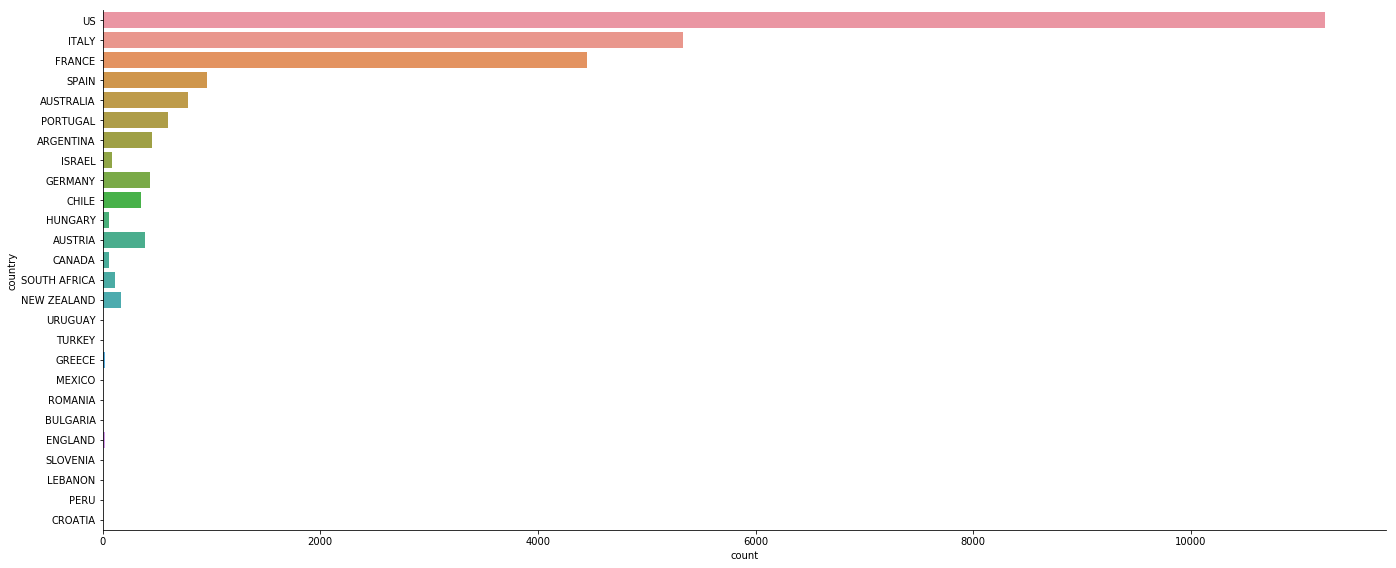

In [57]:
sns.catplot(y="country", kind="count", data=top_10_perc_price.toPandas(), height=7.8, aspect=2.5)

In [58]:
##Filtering for only US
top_10_perc_price.createOrReplaceTempView('top_10_perc_price_us')
top_10_perc_price_us = spark.sql("SELECT * FROM top_10_perc_price_us WHERE country='US'")

#### Distribution of price in different provinces of US

##### Most of highest priced wines in US come from California

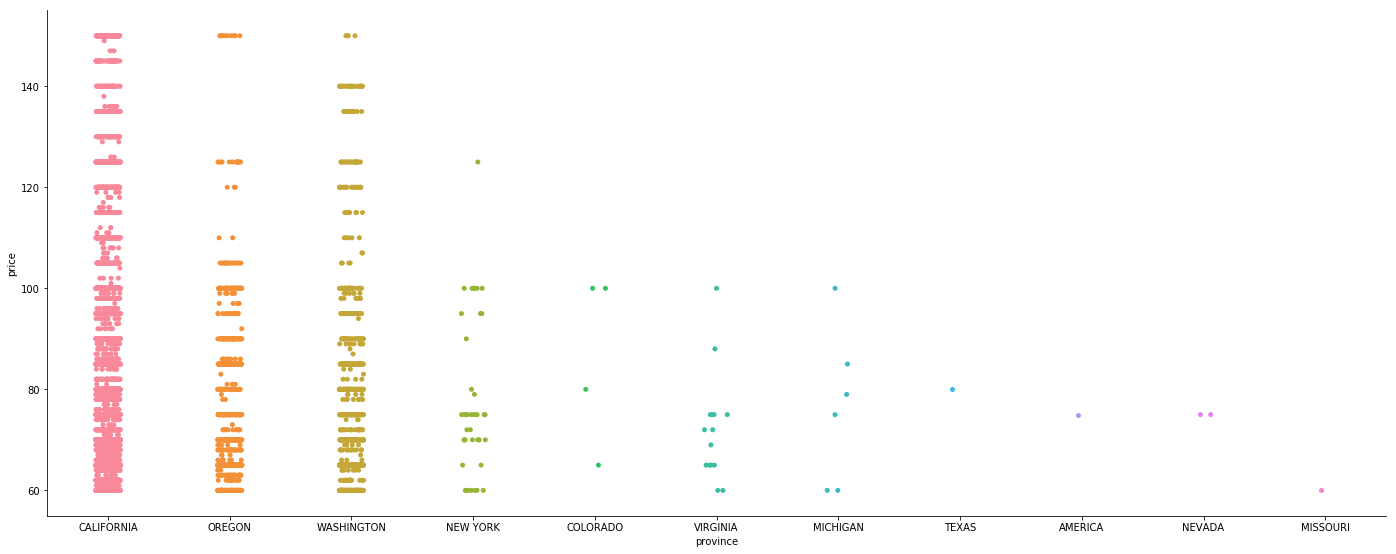

In [59]:
sns.catplot(x="province", y="price", data=top_10_perc_price_us.toPandas(), height=7.8, aspect=2.5);

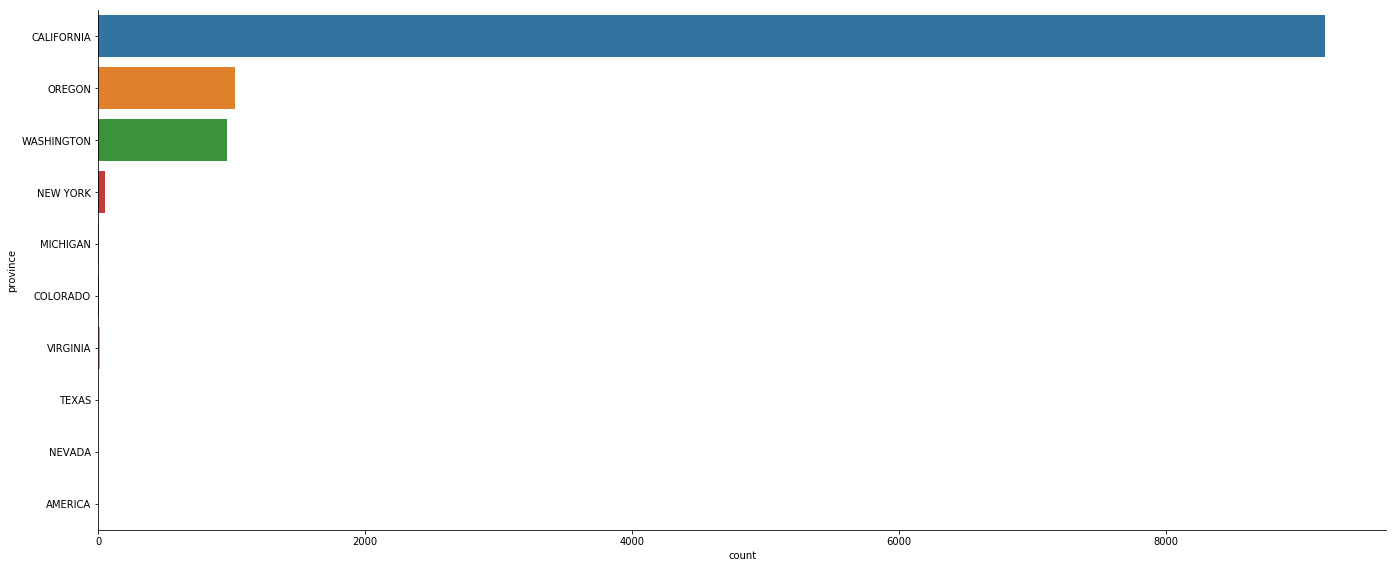

In [60]:
sns.catplot(y="province", kind="count", data=top_10_perc_price_us.toPandas(), height=7.8, aspect=2.5)

In [61]:
# Filtering for only California and point equals 100
top_10_perc_price_us.createOrReplaceTempView('top_10_perc_price_us_cali')
top_10_perc_price_us_cali = spark.sql("SELECT * FROM top_10_perc_price_us_cali WHERE province='CALIFORNIA' AND points=100")

##### Only winery 'WILLIAMS SELYEM' from region 'RUSSIAN RIVER VALLEY' has 100 points for its wine 'PINOT NOIR'

In [62]:
top_10_perc_price_us_cali.toPandas().head(10)

,country,description,points,price,province,region_1,variety,winery
0,US,A SPECTACULAR PINOT NOIR BUT A VERY YOUNG ONE ...,100,100,CALIFORNIA,RUSSIAN RIVER VALLEY,PINOT NOIR,WILLIAMS SELYEM
1,US,A SPECTACULAR PINOT NOIR BUT A VERY YOUNG ONE ...,100,100,CALIFORNIA,RUSSIAN RIVER VALLEY,PINOT NOIR,WILLIAMS SELYEM


### Which winery, region, and country has the most various kinds of wine

In [63]:
#Which winery has the most kinds of wine
from pyspark.sql.functions import *
winerycount = winedfTotal.groupby('winery').agg(count('variety'))
winerymost = winerycount.orderBy(col('count(variety)').desc())
winerymost.toPandas().head(10)
winerymost.count()

18063

##### Winery "Williams Selyem" produces most various kinds of wine among total 17,950 wineries.
As indicated above that Williams Selyem also has the highest point among other winery, the highest point may due to the high variety of wine produced.

[Text(0,0,'WILLIAMS SELYEM'),
 Text(0,0,'TESTAROSSA'),
 Text(0,0,'DFJ VINHOS'),
 Text(0,0,'CHATEAU STE. MICHELLE'),
 Text(0,0,'COLUMBIA CREST'),
 Text(0,0,'CONCHA Y TORO'),
 Text(0,0,'WINES & WINEMAKERS'),
 Text(0,0,'KENDALLJACKSON'),
 Text(0,0,'TRAPICHE'),
 Text(0,0,'KENWOOD')]

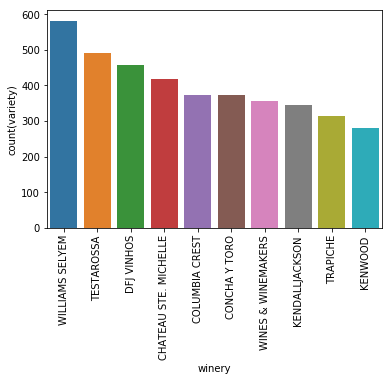

In [64]:
winerytop10 = winerymost.limit(10)
winerytop10_panda = winerytop10.toPandas()
wb = sns.barplot(x='winery',y ='count(variety)', data = winerytop10_panda)
wb.set_xticklabels(wb.get_xticklabels(),rotation=90)

In [65]:
#which region has the most kinds of wine
regioncount = winedfTotal.groupby('region_1').agg(count('variety'))
regionmost = regioncount.orderBy(col('count(variety)').desc())
regionmost.toPandas().head(10)
regionmost.count()

1288

##### Region "Napa Valley" is the top one of 1,278 regions while it scored highest in 500 priced wine in the US.

[Text(0,0,'NAPA VALLEY'),
 Text(0,0,'COLUMBIA VALLEY (WA)'),
 Text(0,0,'RUSSIAN RIVER VALLEY'),
 Text(0,0,'CALIFORNIA'),
 Text(0,0,'MENDOZA'),
 Text(0,0,'PASO ROBLES'),
 Text(0,0,'WILLAMETTE VALLEY'),
 Text(0,0,'RIOJA'),
 Text(0,0,'ALSACE')]

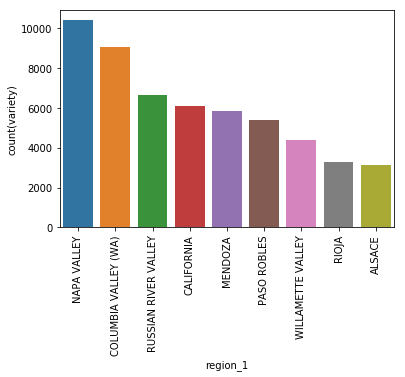

In [66]:
regiontop10 = regionmost.limit(10)
regiontop10_panda = regiontop10.toPandas()
rb = sns.barplot(x='region_1',y ='count(variety)', data = regiontop10_panda)
rb.set_xticklabels(rb.get_xticklabels(),rotation=90)

In [67]:
#which region has the most kinds of wine
countrycount = winedfTotal.groupby('country').agg(count('variety'))
countrymost = countrycount.orderBy(col('count(variety)').desc())
countrymost.toPandas().head(10)
countrymost.count()

48

##### US not only produces most various kinds of wine but also most wine have high price.

[Text(0,0,'US'),
 Text(0,0,'ITALY'),
 Text(0,0,'FRANCE'),
 Text(0,0,'SPAIN'),
 Text(0,0,'CHILE'),
 Text(0,0,'ARGENTINA'),
 Text(0,0,'PORTUGAL'),
 Text(0,0,'AUSTRALIA'),
 Text(0,0,'AUSTRIA'),
 Text(0,0,'NEW ZEALAND')]

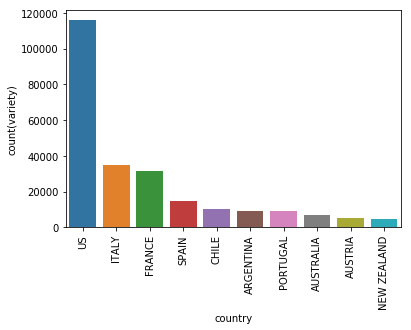

In [68]:
countrytop10 = countrymost.limit(10)
countrytop10_panda = countrytop10.toPandas()
cb = sns.barplot(x='country',y ='count(variety)', data = countrytop10_panda)
cb.set_xticklabels(cb.get_xticklabels(),rotation=90)

### Relationship between price and points 

##### Points vary from 80 to 100 in entire dataset

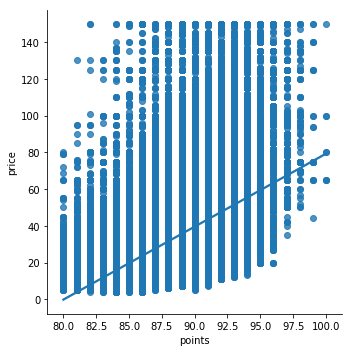

In [69]:
sns.lmplot(x="points", y="price", data=winedfTotal.toPandas())

##### we can see that 75%+ percentile for points and price is 40 and 90 resp 
##### we can see that 25%- percentile for points and price is 16 and 86 resp 

In [70]:
winedfTotal.toPandas().describe()

,points,price
count,255564.000000,255564.000000
mean,88.026921,31.707967
std,3.106354,22.485079
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,150.000000


##### but we don't know what wine is giving most value for its price
##### so we can create a new column, points_price_ratio, to determine that
##### higher the ratio, more value for its price

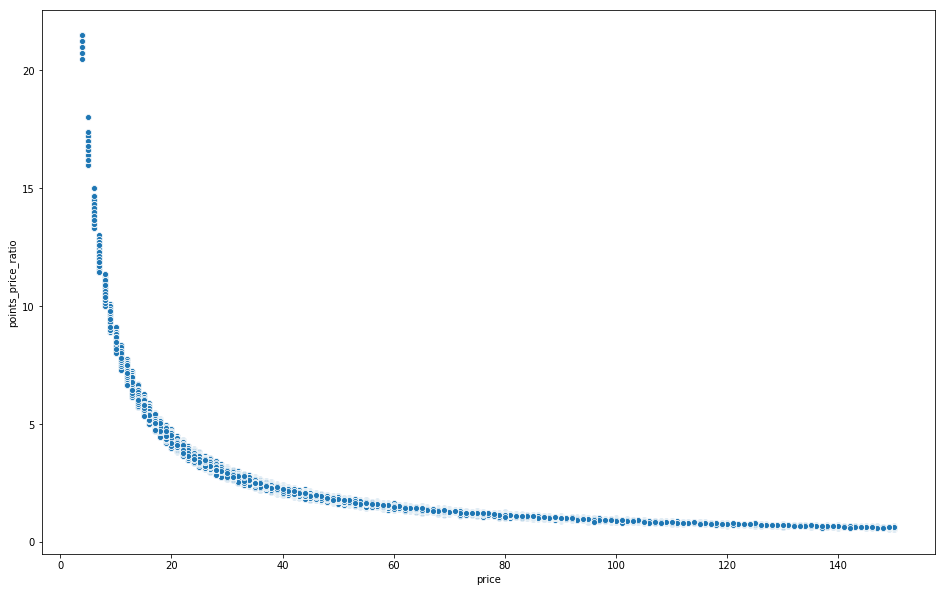

In [71]:
# we can see that lower price wines is giving most value
points_price_ratio = winedfTotal.withColumn("points_price_ratio", winedfTotal['points']/winedfTotal['price'])
plt.figure(figsize=(16, 10))
sns.scatterplot(x="price", y="points_price_ratio", data=points_price_ratio.toPandas())

##### above chart tells that lower price wines gives best value for its price and vice versa
##### please note that it does not necessary tells that lower price wines are best and vice versa

## Using reviews as a feature

Here, we apply the Bag of Words algorithm to the data, turning the description column into a feature. First, we tokenize the data, transforming the description column into a vector, split on white space. We then use CountVectorizer to count the occurrence of the tokens in each description. Finally, we use the IDF function to assign a weight to each word, reflecting its importance.

In [28]:
from pyspark.ml.feature import IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import VectorAssembler


# tokenize description --> vectorize/separate by commas
tokenizer = Tokenizer(inputCol="description", outputCol="words")

# select the top words ordered by term frequency across the description
cv = CountVectorizer(inputCol="words", outputCol="cv")

# IDF used to reflect the importance of a word in the description
idf = IDF(inputCol='cv', outputCol="weighted", minDocFreq=5) #minDocFreq: remove sparse terms

pipeline = Pipeline(stages=[tokenizer, cv, idf])
pipelineFit = pipeline.fit(winedfTotal)
textTransform = pipelineFit.transform(winedfTotal)

In [73]:
textTransform.limit(5).toPandas()

,country,description,points,price,province,region_1,variety,winery,words,cv,weighted
0,US,THE BEST OF THE ARCHERY SUMMIT '03S THIS LIGHT...,89,150,OREGON,WILLAMETTE VALLEY,PINOT NOIR,ARCHERY SUMMIT,"[the, best, of, the, archery, summit, '03s, th...","(3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(0.0625935768014126, 0.6671131567242526, 0.0, ..."
1,ITALY,YOU'LL FIND AROMAS SUGGESTING UNDERBRUSH SCORC...,90,150,TUSCANY,BRUNELLO DI MONTALCINO,SANGIOVESE,COL D'ORCIA,"[you'll, find, aromas, suggesting, underbrush,...","(3.0, 4.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0625935768014126, 0.8894842089656702, 0.456..."
2,US,TANNIC AND CLOSED TO THE POINT OF INACCESSIBIL...,93,150,CALIFORNIA,KNIGHTS VALLEY,CABERNET BLEND,PETER MICHAEL WINERY,"[tannic, and, closed, to, the, point, of, inac...","(3.0, 4.0, 1.0, 3.0, 0.0, 2.0, 3.0, 0.0, 1.0, ...","(0.0625935768014126, 0.8894842089656702, 0.228..."
3,US,AVAILABLE ONLY IN MAGNUMS THIS CHARD CONSISTS ...,94,150,CALIFORNIA,SONOMA COAST,CHARDONNAY,KELLER ESTATE,"[available, only, in, magnums, this, chard, co...","(1.0, 4.0, 4.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, ...","(0.020864525600470866, 0.8894842089656702, 0.9..."
4,US,THIS IS A BARREL SELECTION PRESUMABLY LIMITED ...,94,150,CALIFORNIA,NAPA VALLEY,CABERNET SAUVIGNON,SILVERADO,"[this, is, a, barrel, selection, presumably, l...","(4.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, ...","(0.08345810240188346, 0.4447421044828351, 0.22..."


### Linear regression

We drop all NA values, because regression models cannot run with NAs

In [29]:
winedfTextTransform = textTransform.dropna(how='any', subset = ['region_1'])
winedfTextTransform = winedfTextTransform.dropna(how='any', subset = ['variety'])
winedfTextTransform.toPandas().isna().sum()

country        0
description    0
points         0
price          0
province       0
region_1       0
variety        0
winery         0
words          0
cv             0
weighted       0
dtype: int64

We drop the "description", "words", and "cv" column, because they all are a component of the "weighted" column

In [30]:
cols_to_drop = ['description','words','cv']
winedfTextTransform = winedfTextTransform.drop(*cols_to_drop)
winedfTextTransform.toPandas().head(2)

,country,points,price,province,region_1,variety,winery,weighted
0,ITALY,85,10,CENTRAL ITALY,MONTEPULCIANO D'ABRUZZO,MONTEPULCIANO,TALAMONTI,"(0.0625935768014126, 0.4447421044828351, 0.0, ..."
1,US,89,50,OREGON,WILLAMETTE VALLEY,PINOT NOIR,ERATH,"(0.04172905120094173, 0.4447421044828351, 0.45..."


##### In order to test whether using text analytics improves out model, we create a linear regression model both including and excluding the "weighted" description field, and compare.

#### Excluding "weighted" term

In [32]:
from pyspark.ml.feature import RFormula

supervised_no_w = RFormula(formula="price ~ . -weighted")

In [33]:
fittedRF = supervised_no_w.fit(winedfTextTransform)

In [34]:
preparedDF = fittedRF.transform(winedfTextTransform) 

In [79]:
preparedDF.limit(5).toPandas()

,country,points,price,province,region_1,variety,winery,weighted,features,label
0,ARGENTINA,93,150,MENDOZA PROVINCE,MENDOZA,MALBEC,BODEGA CATENA ZAPATA,"(0.08345810240188346, 0.4447421044828351, 0.22...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 93.0, 0.0, 0.0,...",150.0
1,US,94,150,CALIFORNIA,NAPA VALLEY,CABERNET SAUVIGNON,SILVERADO,"(0.08345810240188346, 0.4447421044828351, 0.22...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.0, 1.0, 0.0,...",150.0
2,US,89,150,OREGON,WILLAMETTE VALLEY,PINOT NOIR,ARCHERY SUMMIT,"(0.0625935768014126, 0.6671131567242526, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 0.0,...",150.0
3,ITALY,93,150,TUSCANY,BRUNELLO DI MONTALCINO,SANGIOVESE,BANFI,"(0.04172905120094173, 0.6671131567242526, 0.68...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 93.0, 0.0, 0.0,...",150.0
4,US,94,150,CALIFORNIA,NAPA VALLEY,BORDEAUXSTYLE RED BLEND,BLACKBIRD VINEYARDS,"(0.1251871536028252, 0.0, 0.6841990093370135, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.0, 1.0, 0.0,...",150.0


In [80]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

In [81]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [82]:
# Fit the model
lrModel = lr.fit(train)

In [83]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: (17482,[0,4,6,7,9,13,14,23,27,30,32,34,40,72,73,74,75,76,77,79,81,82,83,84,86,88,89,90,91,93,99,100,101,103,104,110,111,113,114,115,116,117,118,119,120,121,122,124,126,128,129,130,132,134,137,138,141,142,144,145,148,150,151,157,158,159,161,163,166,167,173,178,179,185,186,190,191,193,195,196,198,199,200,207,208,236,238,240,241,243,245,246,253,265,271,280,288,295,297,301,302,304,311,312,316,319,333,335,342,346,352,361,385,390,392,393,404,410,412,425,434,437,445,449,450,460,500,542,585,598,656,658,672,714,748,811,812,843,844,864,909,936,944,1002,1026,1168,1182,1358,1359,1360,1361,1362,1363,1364,1367,1369,1370,1372,1373,1376,1377,1378,1379,1380,1383,1390,1391,1392,1394,1395,1400,1401,1402,1404,1408,1416,1424,1435,1440,1442,1480,1516,1685,1710,1772,1841,1898,1899,1900,1901,1909,1910,1916,1920,1935,1940,1947,1952,1958,1974,1975,1976,1980,1986,2002,2006,2009,2022,2024,2039,2043,2060,2068,2070,2087,2092,2101,2106,2124,2130,2131,2133,2140,2145,2146,2157,2168,2173,2189,2191,2202,22

In [84]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

print("r2: %f" % trainingSummary.r2)

numIterations: 11
objectiveHistory: [0.49999665954035477, 0.4354732635588685, 0.2928987041725876, 0.2821035609228027, 0.27620445328373355, 0.27452204142792214, 0.2739250206202952, 0.2737121869529422, 0.2735717703106223, 0.27350311467112093, 0.2734580896925985]
+------------------+
|         residuals|
+------------------+
| 95.54396004371577|
| 95.54396004371577|
| 71.57517987663348|
| 86.57517987663348|
| 86.57517987663348|
| 66.58057647556379|
| 66.58057647556379|
| 67.45424129259007|
| 90.53660994369736|
| 83.64717609510555|
| 66.28668721189408|
| 65.71917231357762|
| 65.71917231357762|
| 65.71917231357762|
| 64.52623751106213|
| 64.52623751106213|
|100.19188531625238|
|100.19188531625238|
| 76.05386219452495|
| 80.71917231357762|
+------------------+
only showing top 20 rows

RMSE: 15.268327
r2: 0.557069


In [85]:
from pyspark.ml.evaluation import RegressionEvaluator

fittedTest = lrModel.transform(test)

evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(fittedTest)
evaluator1 = RegressionEvaluator(metricName="r2")
r2 = evaluator1.evaluate(fittedTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Square on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 15.3852
R Square on test data = 0.548026


#### Including "weighted" term

In [31]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="price ~ .")

In [32]:
fittedRF = supervised.fit(winedfTextTransform)

In [33]:
preparedDF = fittedRF.transform(winedfTextTransform) 

In [89]:
preparedDF.limit(5).toPandas()

,country,points,price,province,region_1,variety,winery,weighted,features,label
0,ARGENTINA,93,150,MENDOZA PROVINCE,MENDOZA,MALBEC,BODEGA CATENA ZAPATA,"(0.08345810240188346, 0.4447421044828351, 0.22...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 93.0, 0.0, 0.0,...",150.0
1,US,94,150,CALIFORNIA,NAPA VALLEY,CABERNET SAUVIGNON,SILVERADO,"(0.08345810240188346, 0.4447421044828351, 0.22...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.0, 1.0, 0.0,...",150.0
2,US,89,150,OREGON,WILLAMETTE VALLEY,PINOT NOIR,ARCHERY SUMMIT,"(0.0625935768014126, 0.6671131567242526, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 0.0,...",150.0
3,ITALY,93,150,TUSCANY,BRUNELLO DI MONTALCINO,SANGIOVESE,BANFI,"(0.04172905120094173, 0.6671131567242526, 0.68...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 93.0, 0.0, 0.0,...",150.0
4,US,94,150,CALIFORNIA,NAPA VALLEY,BORDEAUXSTYLE RED BLEND,BLACKBIRD VINEYARDS,"(0.1251871536028252, 0.0, 0.6841990093370135, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.0, 1.0, 0.0,...",150.0


In [35]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

In [37]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [92]:
# Fit the model
lrModel = lr.fit(train)

In [93]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: (90422,[0,3,4,6,7,8,9,12,13,14,23,27,30,32,33,34,38,40,72,73,74,75,76,77,82,83,84,86,89,90,91,93,97,99,100,101,103,104,111,114,115,116,117,118,119,120,121,122,124,128,129,130,132,137,142,144,145,148,150,151,157,158,159,161,163,166,167,173,178,179,185,186,190,191,193,195,196,198,207,208,209,236,238,240,241,243,245,246,253,265,266,271,280,282,288,295,297,301,302,304,311,312,316,319,324,333,335,342,346,352,361,385,390,392,393,410,412,425,434,437,445,449,450,500,542,585,598,656,658,714,811,812,843,844,864,909,936,1002,1358,1360,1361,1362,1363,1364,1365,1366,1369,1370,1373,1377,1378,1379,1381,1384,1385,1390,1394,1395,1416,1424,1440,1442,1444,1516,1685,1710,1772,1841,1898,1899,1900,1901,1908,1909,1920,1927,1935,1940,1947,1952,1958,1974,1975,1976,1980,1986,2006,2009,2022,2024,2039,2043,2060,2068,2087,2092,2101,2124,2130,2133,2140,2145,2146,2168,2173,2189,2191,2222,2227,2237,2244,2256,2260,2334,2347,2359,2377,2380,2397,2398,2406,2412,2429,2440,2450,2455,2466,2467,2471,2478,2495,2

In [94]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

print("r2: %f" % trainingSummary.r2)

numIterations: 11
objectiveHistory: [0.49999665960730283, 0.4538357895450542, 0.322345676068794, 0.3058862806355552, 0.28005618285500783, 0.2715323581959812, 0.2659771735179942, 0.26373235973255654, 0.26294660947149073, 0.2628454773873014, 0.2624392027007358]
+------------------+
|         residuals|
+------------------+
| 88.40563020771165|
| 88.40563020771165|
| 75.22379659837398|
| 80.58606616028536|
| 80.58606616028536|
| 74.49504795710638|
| 74.49504795710638|
|  75.6226589058194|
| 91.59666171456959|
| 92.50306548089603|
| 70.47663753228827|
| 66.04589298830732|
| 66.04589298830732|
| 67.02000623437127|
| 71.24308957564543|
| 71.24308957564543|
|107.16902994409085|
|107.16902994409085|
|49.185621785529605|
| 79.23284367299377|
+------------------+
only showing top 20 rows

RMSE: 14.586964
r2: 0.596601


In [95]:
from pyspark.ml.evaluation import RegressionEvaluator

fittedTest = lrModel.transform(test)

evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(fittedTest)
evaluator1 = RegressionEvaluator(metricName="r2")
r2 = evaluator1.evaluate(fittedTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Square on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 14.7552
R Square on test data = 0.588085


##### Including the weighted term slightly increases r2, so we will include it as a feature in future models. We run other models to see whether we can improve on the r2.

### Tune the Linear Model
In order to acheive a better result, we try to tune the hyperparameter of linear model.

In [46]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
lr = LinearRegression().setLabelCol("label").setFeaturesCol("features")

evaluator = RegressionEvaluator(metricName="r2")

In [47]:
params = ParamGridBuilder()\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.1, 2.0])\
  .build()

In [48]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=params, evaluator=evaluator, numFolds=3)

In [ ]:
cvfit = cv.fit(train)

In [50]:
r2 = evaluator.evaluate(cvfit.transform(test))
print("R Square on test data = %g" % r2)

R Square on test data = 0.21754


In [51]:
evaluator1 = RegressionEvaluator(metricName="rmse")
cv = CrossValidator(estimator=lr, estimatorParamMaps=params, evaluator=evaluator1, numFolds=3)

In [ ]:
cvfit = cv.fit(train)

In [43]:
rmse = evaluator1.evaluate(cvfit.transform(test))
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 16.5027


The tuning result doesn't seem improving the model. Therefore, our best linear model is using hyperparamers as default.

#### Decision Tree

In fitting the decision tree model, we faced a problem that the decision tree model with original dataframe is not able to work. We assumed that it is because of limited processing power of our VM, however even after increasing our VM configuration to 16 core and 60gb RAM, it was still stuck. Due to the limitation of our VM instance and the extremly long running time of decision tree model, we decide to use a small sample size to test the decision tree model. The sample size is randomly selected from previous dataframe fitted with RFormula.

In [22]:
Sample = preparedDF.sample(False,0.1)
Sample.count()

21314

In order to limit the running time of decision tree, we set tree depth as 5 and seed as 10.

In [23]:
from pyspark.ml.regression import DecisionTreeRegressor

(Train, Test) = Sample.randomSplit([0.7, 0.3])
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth = 5, seed = 10)
print(dtr.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
ma

In [24]:
dtrmodel = dtr.fit(Train)

In [25]:
predictions = dtrmodel.transform(Test)
predictions.select("prediction", "label", "features").show(5)

+-----------------+-----+--------------------+
|       prediction|label|            features|
+-----------------+-----+--------------------+
|15.96419500204834|  9.0|(17501,[4,9,31,95...|
|15.96419500204834| 17.0|(17501,[4,6,50,31...|
|15.96419500204834| 43.0|(17501,[4,7,31,18...|
|15.96419500204834|  4.0|(17501,[5,11,37,1...|
|28.26536312849162|  4.0|(17501,[2,14,33,6...|
+-----------------+-----+--------------------+
only showing top 5 rows



In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
evaluator1 = RegressionEvaluator(metricName="r2")
r2 = evaluator1.evaluate(predictions)
print("R Square on test data = %g" % r2)
print(dtrmodel)

Root Mean Squared Error (RMSE) on test data = 17.4397
R Square on test data = 0.109779
DecisionTreeRegressionModel (uid=DecisionTreeRegressor_995b82a041c2) of depth 5 with 59 nodes


From our sample decision tree, the RMSE of decision tree is higher than linear regression which means that the standard deviation of decision tree model is larger than linear regression. The lower r2 of decison tree indicates that the linear regression model is better aligned with data than decision tree.

#### Random Forest
In random forest model, we still use a small sample size to analysis due to the limitation we have. Unfortunately, we tried several times and random forest model is not running through. If the model is working, the result will be goood for our model comparision.

In [30]:
Sample = preparedDF.sample(False,0.1)
Sample.count()

21403

In [31]:
from pyspark.ml.regression import RandomForestRegressor

(Train, Test) = Sample.randomSplit([0.7, 0.3])
rf = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth = 5, seed = 10)
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

rfmodel = rf.fit(Train)
predictions = rfmodel.transform(Test)
predictions.select("prediction", "label", "features").show(5)
evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(model)

## Summary

We recommend using linear regression model to predict the wine price after comparing linear and decision tree regression model. Based on RMSE and R2, we find out that the linear regression fits better for our dataset. 